## **Lưu ý: Sau mỗi cell `Question` là 1 cell `Answer`**

* Data : 35.000 Images về cảm xúc khuôn mặt
* Model : KNN, Gaussian Naive Bayes, Random Forest, MLP, CNN

------

### **Các bước thực hiện :**

1. Chuẩn bị dữ liệu
2. Kiểm tra xem dữ liệu có cân bằng không
3. Shuffle dữ liệu để tránh bias không cần thiết
4. Parsing Data để show image
5. Chuẩn hóa data
6. Dùng các kỹ thuật liên quan đến PCA để giảm chiều dữ liệu
7. Chia dữ liệu thành các train, test splits
8. Sử dụng các ML models cho dữ liệu chưa qua PCA, và dữ liệu đã qua PCA để so sánh thời gian train và hiệu suất
9. Search siêu tham số nếu có thể (Trong đó, có cả quá trình search với GridSearchCV() và search thủ công (vì GridSearchCV không hiển thị được tiến trình search, làm người ta sốt ruột))

------

*Note 1: Quá trình search siêu tham số (thủ công) nằm ở model KNN và MLP*




## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

### Chuẩn bị dữ liệu

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Đường dẫn tới file CSV trong Google Drive
file_path = '/content/drive/My Drive/Data/icml_face_data.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
df.shape

(35887, 2)

In [ ]:
""" Kiểm tra số lượng row của từng class """

emotion_counts = df['emotion'].value_counts()
print(emotion_counts)

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


### Shuffle dữ liệu để đảm bảo model không bias một cách bất thường

In [ ]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_shuffled.shape

(35887, 2)

### Trục quan hóa images

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df_shuffled)

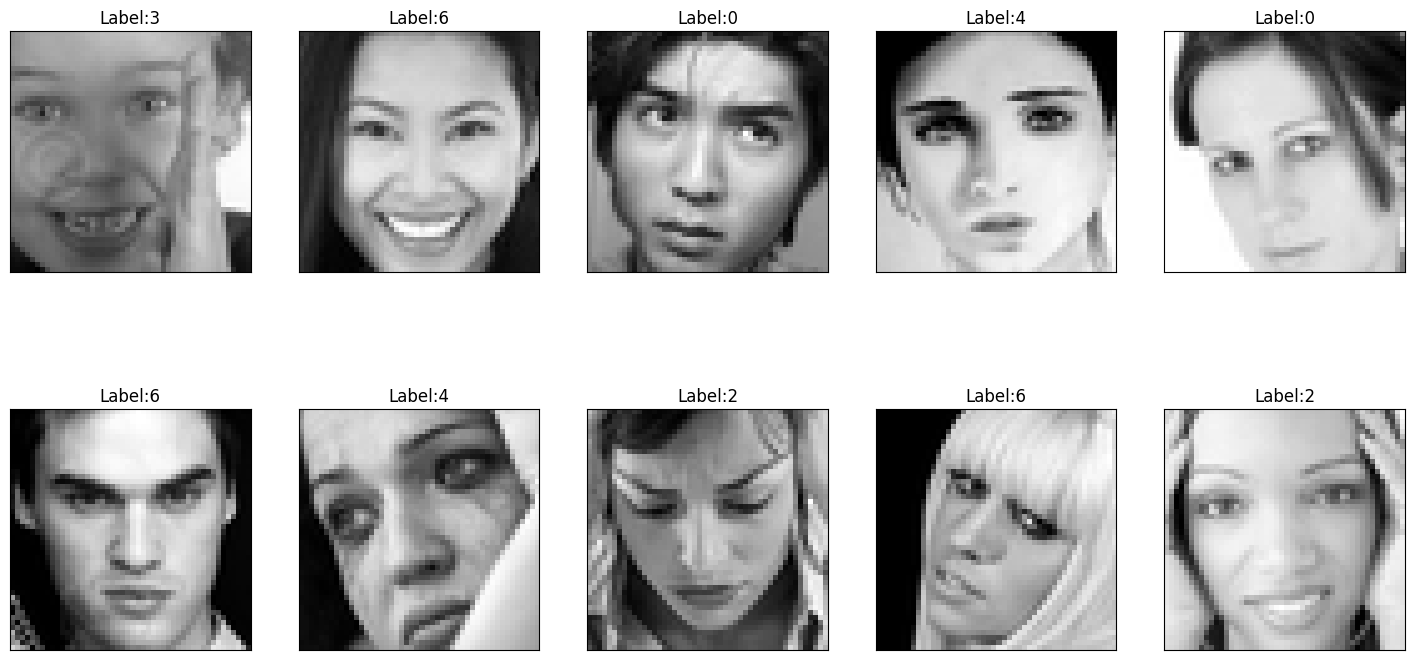

In [ ]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

### **Question 1: Can you visualize the data projected onto two principal components? (2 points)**

***Answer 1: Sử dụng PCA với (n_components = 2) và plot lên biểu đồ trong không gian 2 chiều, với Matplotlib***

In [ ]:
from sklearn.decomposition import PCA

# Dùng PCA
images_reshaped = images.reshape(images.shape[0], -1)
pca = PCA(n_components=2)
pca.fit(images_reshaped)

PCA(n_components=2)

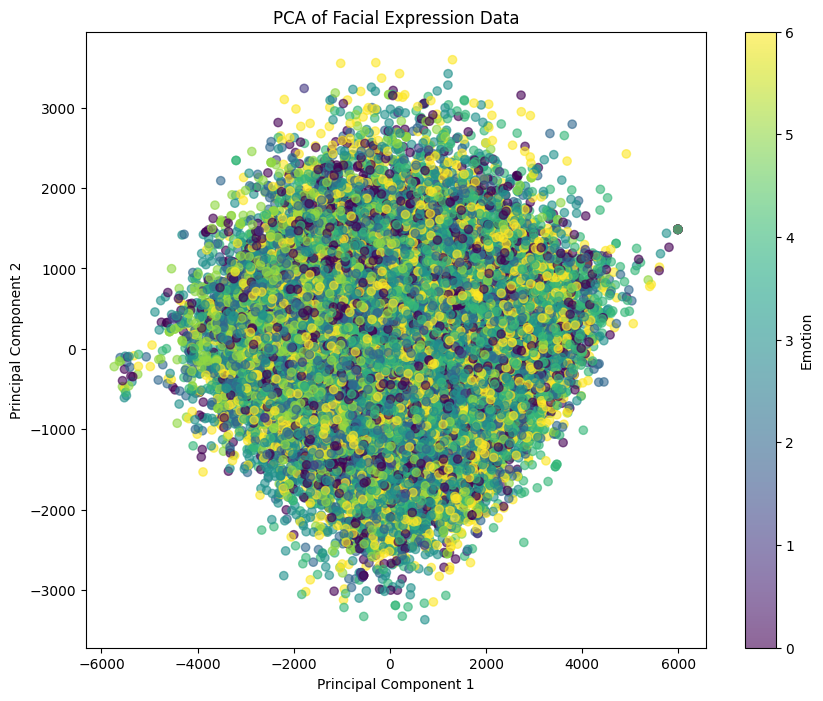

In [ ]:
import matplotlib.pyplot as plt

""" ------------------------------------------------------------------------"""
images_pca = pca.transform(images_reshaped)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=range(7), label='Emotion')
plt.title('PCA of Facial Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Plot data lên biểu đồ trong không gian 3 chiều

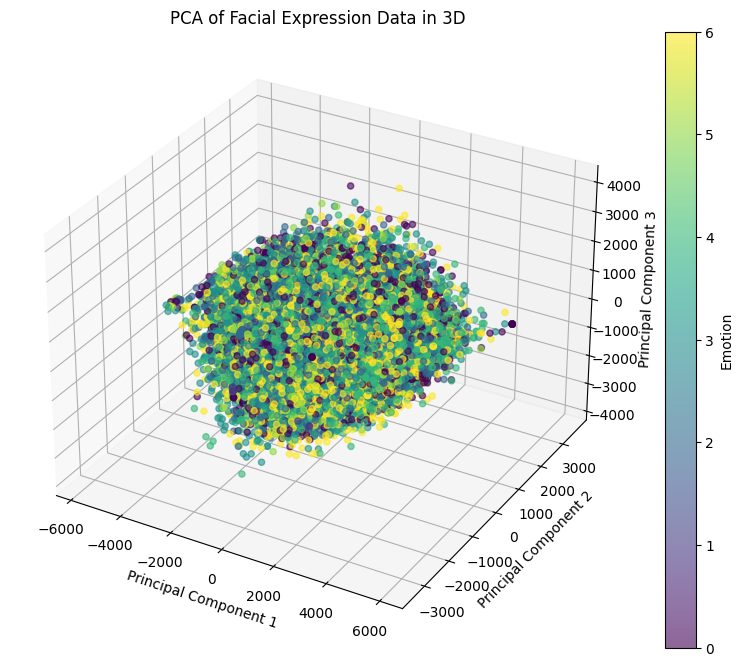

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Dùng PCA để giảm chiều dữ liệu xuống còn 3 thành phần chính
pca = PCA(n_components=3)
images_pca_3d = pca.fit_transform(images_reshaped)

# Tạo một figure và một subplot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ biểu đồ phân tán 3D
scatter = ax.scatter(images_pca_3d[:, 0], images_pca_3d[:, 1], images_pca_3d[:, 2], c=labels, cmap='viridis', alpha=0.6)

# Thêm thanh màu và các nhãn
cbar = plt.colorbar(scatter, ticks=range(7), label='Emotion')
cbar.set_label('Emotion')

# Thêm tiêu đề và nhãn trục
ax.set_title('PCA of Facial Expression Data in 3D')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Hiển thị biểu đồ
plt.show()

In [ ]:
"""
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
# pca.fit(images) ## modify images' array to the appropriate shape
"""

In [ ]:
"""
## transform for visualizing here
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape
# images_pca.shape
"""

### **Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_``` ? Explain your selection process. (2 points)**

***Answer 2:***

--------

*Trong các tấm ảnh, ta thấy rằng khuôn mặt chiếm gần hết các pixel trong tấm ảnh, do đó ta giữ lại một lượng lớn thành phần chính*

*Tuy nhiên, nếu muốn xác định được là cần giữ lại bao nhiêu % lượng thông tin để tối ưu, ta cần thí nghiệm. Ví dụ, ta thí nghiệm với 3 ngưỡng là [87, 90, 93] phần trăm. Tất nhiên với mỗi ngưỡng này, ta tìm được số lượng thành phần chính tương ứng (number_of_combonents)*

*Ta có thể dùng vòng lặp, nhưng vì giai đoạn này không quá quan trọng nên ta tiết kiệm thời gian bằng cách chọn con số 93*

*Trong phần test thử pca dưới đây, ta tìm được số lượng thành phần chính tối ưu để giữ lại 93% lượng thông tin của dữ liệu là `168`, ta sẽ apply nó vào data (data mà đã được chuẩn hóa)*

### Chuẩn hóa dữ liệu với StandardScaler()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# normalize
scaler = MinMaxScaler()
images_normalized = scaler.fit_transform(images_reshaped)

In [ ]:
images_normalized

array([[0.55686275, 0.58039216, 0.59607843, ..., 0.06666667, 0.0745098 ,
        0.09411765],
       [0.23529412, 0.24705882, 0.21176471, ..., 0.13333333, 0.1254902 ,
        0.12941176],
       [0.52156863, 0.18039216, 0.12156863, ..., 0.49411765, 0.55686275,
        0.57647059],
       ...,
       [0.38039216, 0.36470588, 0.23921569, ..., 0.32156863, 0.41568627,
        0.63529412],
       [0.99607843, 0.89411765, 0.84705882, ..., 0.74509804, 0.85490196,
        0.87843137],
       [0.46666667, 0.39607843, 0.07058824, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
images_normalized.shape

(35887, 2304)

### Dùng PCA giữ lại khoảng 93% phân phối của tấm ảnh, ta tìm được số lượng thành phần chính là 171

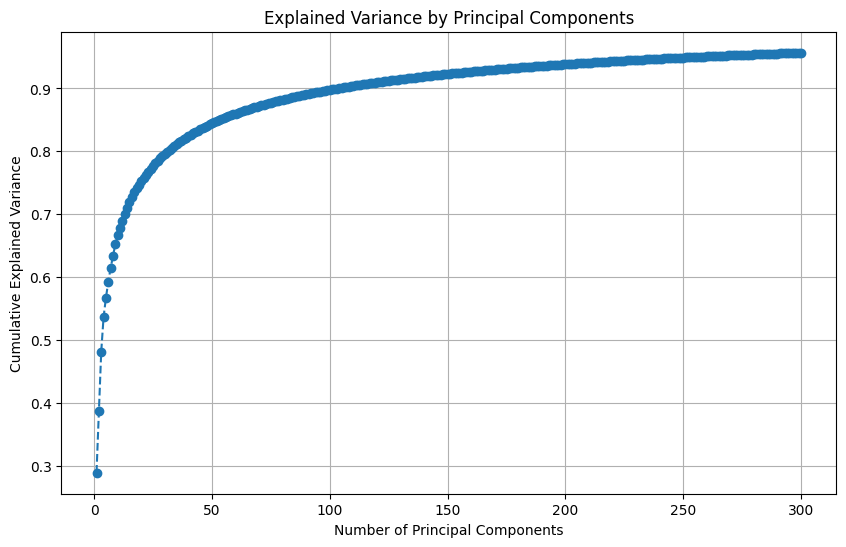

Optimal number of principal components: 171


In [ ]:
pca2 = PCA(n_components = 300)
pca2.fit(images_reshaped)

explained_variance_ratio = pca2.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

optimal_num_components = np.argmax(cumulative_explained_variance >= 0.93) + 1
print(f'Optimal number of principal components: {optimal_num_components}')

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

### **Question 3:**
Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

### **Answer 3:**

### **Xem các bước làm bên dưới**

In [ ]:
from sklearn.decomposition import PCA

pca_171 = PCA(n_components=171)
images_pca = pca_171.fit_transform(images_normalized)

In [ ]:
print(f'Shape of data after PCA: {images_pca.shape}')

Shape of data after PCA: (35887, 171)


### **Tiến hành sử dụng 4 model cho cả 2 data gốc và data sau khi đã dùng PCA**

------

**Các model khả thi:**

1. SVM
2. Random Forest
3. KNN
4. MLP

### Split data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(images_normalized, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train_norm.shape[0]}, Testing set size: {X_test_norm.shape[0]}")

Training set size: 28709, Testing set size: 7178


In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(images_pca,
                                                                    labels,
                                                                    test_size=0.2,
                                                                    random_state=42)

print(f"Training set size: {X_train_pca.shape[0]}, Testing set size: {X_test_pca.shape[0]}")

Training set size: 28709, Testing set size: 7178


### **Model 1.1: `KNN()` trên dữ liệu gốc**

* Mất 39 giây
* Accuracy : 35.04%

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import numpy as np

knn_model = KNeighborsClassifier(n_neighbors=5)


num_steps = 100
progress_bar = tqdm(total=num_steps, desc="Training Progress")


knn_model.fit(X_train_norm, y_train_norm)
for i in range(num_steps):
    progress_bar.update(1)
    if (i + 1) % (num_steps // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")

progress_bar.close()


y_pred_knn = knn_model.predict(X_test_norm)
accuracy_knn = accuracy_score(y_test_norm, y_pred_knn)
print(f"Accuracy on normalized data: {accuracy_knn}")
print(classification_report(y_test_norm, y_pred_knn))
print(confusion_matrix(y_test_norm, y_pred_knn))

Training Progress: 100%|██████████| 100/100 [00:00<00:00, 859.78it/s]


Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

### **Model 1.2: `KNN()` trên dữ liệu sau quá trình pca**

- Mất 5 giây
- Accuracy : 36.28%

--> Giảm được rất nhiều % thời gian train, nhưng hiệu suất vẫn không bị giảm, nhờ bỏ bớt các thành phần không phải là thành phần chính.

In [ ]:
knn_model_2 = KNeighborsClassifier(n_neighbors=5)


num_steps_2 = 100
progress_bar_2 = tqdm(total=num_steps_2, desc="Training Progress")


knn_model_2.fit(X_train_pca, y_train_pca)
for i in range(num_steps_2):
    progress_bar_2.update(1)
    if (i + 1) % (num_steps_2 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")


progress_bar_2.close()


y_pred_knn_2 = knn_model_2.predict(X_test_pca)
accuracy_knn_2 = accuracy_score(y_test_pca, y_pred_knn_2)
print(f"Accuracy on normalized data: {accuracy_knn_2}")
print(classification_report(y_test_pca, y_pred_knn_2))
print(confusion_matrix(y_test_pca, y_pred_knn_2))

Training Progress: 100%|██████████| 100/100 [00:00<00:00, 4253.00it/s]

Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

Accuracy on normalized data: 0.36277514628030094
              precision    recall  f1-score   support

           0       0.30      0.31      0.30      1007
           1       0.23      0.32      0.27       103
           2       0.33      0.29      0.31      1043
           3       0.42      0.51      0.46      1814
           4       0.32      0.25      0.28      1197
           5       0.52      0.42      0.47       812
           6       0.30      0.32      0.31      1202

    accuracy                           0.36      7178
   macro avg       0.35      0.35      0.34      7178
weighted avg       0.36      0.36      0.36      7178

[[308  10 124 227 121  57 160]
 [ 16  33  10  15  14   6   9]
 [127  16 304 226 157  75 138]
 [173  32 164 932 158  62 293]
 [190  17 126 298 298  49 219]
 [ 71  13  85 147  66 342  88]
 [137  21 111 350 131  65 387]]


### **Model 1.3: `KNN()` giống như model 1.2, nhưng điều chỉnh lại siêu tham số**

- Mất 1 phút để train
- Accuracy : 41.3%

--> Giảm được rất nhiều % thời gian train, nhưng hiệu suất vẫn không bị ảnh hưởng

In [ ]:
knn_model_3 = KNeighborsClassifier(n_neighbors=5,
                                   weights='distance',
                                   algorithm = 'ball_tree')


num_steps_3 = 100
progress_bar_3 = tqdm(total=num_steps_3, desc="Training Progress")


knn_model_3.fit(X_train_pca, y_train_pca)
for i in range(num_steps_3):
    progress_bar_3.update(1)
    if (i + 1) % (num_steps_3 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")


progress_bar_3.close()


y_pred_knn_3 = knn_model_3.predict(X_test_pca)
accuracy_knn_3 = accuracy_score(y_test_pca, y_pred_knn_3)
print(f"Accuracy on normalized data: {accuracy_knn_3}")
print(classification_report(y_test_pca, y_pred_knn_3))
print(confusion_matrix(y_test_pca, y_pred_knn_3))

Training Progress: 100%|██████████| 100/100 [00:01<00:00, 82.34it/s]


Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

### **Model 1.4: `KNN()` trên dữ liệu sau quá trình pca, sử dụng `GridSearchCV()`**

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from tqdm import tqdm


# Các tham số cho GridSearchCV
param_grid_3 = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Khởi tạo mô hình KNN
knn_model_3 = KNeighborsClassifier()

# Sử dụng GridSearchCV để tìm siêu tham số tốt nhất
grid_search = GridSearchCV(knn_model_3, param_grid_3, cv=5, scoring='accuracy')

# Giả lập quá trình huấn luyện với tqdm
num_steps_3 = 100
progress_bar_3 = tqdm(total=num_steps_3, desc="Training Progress")

# Huấn luyện mô hình
for i in range(num_steps_3):
    if i == 0:
        grid_search.fit(X_train_pca, y_train_pca)
    progress_bar_3.update(1)
    if (i + 1) % (num_steps_3 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")

progress_bar_3.close()

# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_

# Dự đoán nhãn của tập kiểm tra với mô hình tốt nhất
y_pred_knn_3 = best_model.predict(X_test_pca)

# Đánh giá độ chính xác của mô hình
accuracy_knn_3 = accuracy_score(y_test_pca, y_pred_knn_3)
print(f"Accuracy on normalized data: {accuracy_knn_3}")
print(classification_report(y_test_pca, y_pred_knn_3))
print(confusion_matrix(y_test_pca, y_pred_knn_3))

# In ra các siêu tham số tốt nhất
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### **Model 1.5, 1.6, 1.7, 1.8, ...: `KNN()` trên dữ liệu sau quá trình pca, thay đổi siêu tham số một cách thủ công**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model_3 = KNeighborsClassifier(n_neighbors=3,
                                   weights='distance',
                                   algorithm = 'kd_tree')


num_steps_3 = 100
progress_bar_3 = tqdm(total=num_steps_3, desc="Training Progress")


knn_model_3.fit(X_train_pca, y_train_pca)
for i in range(num_steps_3):
    progress_bar_3.update(1)
    if (i + 1) % (num_steps_3 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")


progress_bar_3.close()


y_pred_knn_3 = knn_model_3.predict(X_test_pca)
accuracy_knn_3 = accuracy_score(y_test_pca, y_pred_knn_3)
print(f"Accuracy on normalized data: {accuracy_knn_3}")
print(classification_report(y_test_pca, y_pred_knn_3))
print(confusion_matrix(y_test_pca, y_pred_knn_3))

Training Progress: 100%|██████████| 100/100 [00:01<00:00, 60.71it/s]


Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

In [ ]:
knn_model_3 = KNeighborsClassifier(n_neighbors=5,
                                   weights='distance',
                                   algorithm = 'kd_tree')


num_steps_3 = 100
progress_bar_3 = tqdm(total=num_steps_3, desc="Training Progress")


knn_model_3.fit(X_train_pca, y_train_pca)
for i in range(num_steps_3):
    progress_bar_3.update(1)
    if (i + 1) % (num_steps_3 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")


progress_bar_3.close()


y_pred_knn_3 = knn_model_3.predict(X_test_pca)
accuracy_knn_3 = accuracy_score(y_test_pca, y_pred_knn_3)
print(f"Accuracy on normalized data: {accuracy_knn_3}")
print(classification_report(y_test_pca, y_pred_knn_3))
print(confusion_matrix(y_test_pca, y_pred_knn_3))

Training Progress: 100%|██████████| 100/100 [00:01<00:00, 71.13it/s]


Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

In [ ]:
knn_model_3 = KNeighborsClassifier(n_neighbors=7,
                                   weights='distance',
                                   algorithm = 'kd_tree')


num_steps_3 = 100
progress_bar_3 = tqdm(total=num_steps_3, desc="Training Progress")


knn_model_3.fit(X_train_pca, y_train_pca)
for i in range(num_steps_3):
    progress_bar_3.update(1)
    if (i + 1) % (num_steps_3 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")


progress_bar_3.close()


y_pred_knn_3 = knn_model_3.predict(X_test_pca)
accuracy_knn_3 = accuracy_score(y_test_pca, y_pred_knn_3)
print(f"Accuracy on normalized data: {accuracy_knn_3}")
print(classification_report(y_test_pca, y_pred_knn_3))
print(confusion_matrix(y_test_pca, y_pred_knn_3))

Training Progress: 100%|██████████| 100/100 [00:01<00:00, 72.84it/s]


Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

In [ ]:
knn_model_3 = KNeighborsClassifier(n_neighbors=5,
                                   weights='distance',
                                   algorithm = 'brute')


num_steps_3 = 100
progress_bar_3 = tqdm(total=num_steps_3, desc="Training Progress")


knn_model_3.fit(X_train_pca, y_train_pca)
for i in range(num_steps_3):
    progress_bar_3.update(1)
    if (i + 1) % (num_steps_3 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")


progress_bar_3.close()


y_pred_knn_3 = knn_model_3.predict(X_test_pca)
accuracy_knn_3 = accuracy_score(y_test_pca, y_pred_knn_3)
print(f"Accuracy on normalized data: {accuracy_knn_3}")
print(classification_report(y_test_pca, y_pred_knn_3))
print(confusion_matrix(y_test_pca, y_pred_knn_3))

Training Progress: 100%|██████████| 100/100 [00:00<00:00, 4598.36it/s]

Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

Accuracy on normalized data: 0.4045695179715798
              precision    recall  f1-score   support

           0       0.40      0.27      0.32      1007
           1       0.38      0.44      0.41       103
           2       0.43      0.34      0.38      1043
           3       0.45      0.50      0.47      1814
           4       0.34      0.30      0.32      1197
           5       0.58      0.61      0.59       812
           6       0.30      0.40      0.34      1202

    accuracy                           0.40      7178
   macro avg       0.41      0.41      0.40      7178
weighted avg       0.41      0.40      0.40      7178

[[273   9  99 229 139  65 193]
 [  8  45   7  11  14   9   9]
 [ 72   8 351 199 166  78 169]
 [104  19 119 898 191  87 396]
 [122  16 113 256 362  53 275]
 [ 25   7  41 106  55 493  85]
 [ 84  15  88 314 149  70 482]]


In [ ]:
knn_model_3 = KNeighborsClassifier(n_neighbors=7,
                                   weights='distance',
                                   algorithm = 'brute')


num_steps_3 = 100
progress_bar_3 = tqdm(total=num_steps_3, desc="Training Progress")


knn_model_3.fit(X_train_pca, y_train_pca)
for i in range(num_steps_3):
    progress_bar_3.update(1)
    if (i + 1) % (num_steps_3 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")


progress_bar_3.close()


y_pred_knn_3 = knn_model_3.predict(X_test_pca)
accuracy_knn_3 = accuracy_score(y_test_pca, y_pred_knn_3)
print(f"Accuracy on normalized data: {accuracy_knn_3}")
print(classification_report(y_test_pca, y_pred_knn_3))
print(confusion_matrix(y_test_pca, y_pred_knn_3))

Training Progress: 100%|██████████| 100/100 [00:00<00:00, 3616.50it/s]

Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

Accuracy on normalized data: 0.3976037893563667
              precision    recall  f1-score   support

           0       0.39      0.25      0.31      1007
           1       0.40      0.41      0.41       103
           2       0.43      0.31      0.36      1043
           3       0.43      0.51      0.47      1814
           4       0.33      0.29      0.31      1197
           5       0.58      0.59      0.58       812
           6       0.29      0.39      0.33      1202

    accuracy                           0.40      7178
   macro avg       0.41      0.39      0.40      7178
weighted avg       0.40      0.40      0.39      7178

[[256   6  93 258 131  61 202]
 [  7  42   6  16  14  10   8]
 [ 65   5 328 229 166  82 168]
 [104  17 121 934 179  77 382]
 [114  16  97 276 345  54 295]
 [ 24   7  42 121  50 478  90]
 [ 88  11  72 337 154  69 471]]


In [ ]:
knn_model_3 = KNeighborsClassifier(n_neighbors=3,
                                   weights='uniform',
                                   algorithm = 'brute')


num_steps_3 = 100
progress_bar_3 = tqdm(total=num_steps_3, desc="Training Progress")


knn_model_3.fit(X_train_pca, y_train_pca)
for i in range(num_steps_3):
    progress_bar_3.update(1)
    if (i + 1) % (num_steps_3 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")


progress_bar_3.close()


y_pred_knn_3 = knn_model_3.predict(X_test_pca)
accuracy_knn_3 = accuracy_score(y_test_pca, y_pred_knn_3)
print(f"Accuracy on normalized data: {accuracy_knn_3}")
print(classification_report(y_test_pca, y_pred_knn_3))
print(confusion_matrix(y_test_pca, y_pred_knn_3))

Training Progress: 100%|██████████| 100/100 [00:00<00:00, 2348.22it/s]

Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

Accuracy on normalized data: 0.3488436890498746
              precision    recall  f1-score   support

           0       0.26      0.38      0.31      1007
           1       0.17      0.42      0.24       103
           2       0.31      0.37      0.34      1043
           3       0.41      0.41      0.41      1814
           4       0.35      0.21      0.26      1197
           5       0.58      0.42      0.49       812
           6       0.33      0.29      0.31      1202

    accuracy                           0.35      7178
   macro avg       0.34      0.36      0.34      7178
weighted avg       0.37      0.35      0.35      7178

[[386  25 143 206  79  46 122]
 [ 16  43  12  14   8   3   7]
 [188  30 388 164 102  62 109]
 [328  51 244 749 121  57 264]
 [257  44 190 260 246  31 169]
 [ 84  19 120 139  56 340  54]
 [229  38 154 286 100  43 352]]


### **Model 2.1: `GaussNB()` trên dữ liệu chưa pca**

* Mất 1 phút
* Accuracy : 21.1%

In [ ]:
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
import numpy as np

# Tạo mô hình Gaussian Naive Bayes
gauss_nb_model = GaussianNB(priors=None,
                            var_smoothing=1e-9)

# Huấn luyện mô hình và in ra tiến trình
total_samples = len(X_train_norm)
percent_step = total_samples // 100

for i in range(total_samples):
    gauss_nb_model.partial_fit(X_train_norm[i:i+1, :],
                               y_train_norm[i:i+1],
                               classes=np.unique(y_train_norm))
    if (i + 1) % percent_step == 0:
        print(f"Đã huấn luyện xong {i + 1} phần trăm")

# Dự đoán và đánh giá mô hình
y_pred_gauss_nb = gauss_nb_model.predict(X_test_norm)

accuracy_gauss_nb = accuracy_score(y_test_norm,
                                   y_pred_gauss_nb)

print(f"Accuracy on test set: {accuracy_gauss_nb}")

print(classification_report(y_test_norm,
                            y_pred_gauss_nb))

print(confusion_matrix(y_test_norm,
                       y_pred_gauss_nb))

Đã huấn luyện xong 287 phần trăm
Đã huấn luyện xong 574 phần trăm
Đã huấn luyện xong 861 phần trăm
Đã huấn luyện xong 1148 phần trăm
Đã huấn luyện xong 1435 phần trăm
Đã huấn luyện xong 1722 phần trăm
Đã huấn luyện xong 2009 phần trăm
Đã huấn luyện xong 2296 phần trăm
Đã huấn luyện xong 2583 phần trăm
Đã huấn luyện xong 2870 phần trăm
Đã huấn luyện xong 3157 phần trăm
Đã huấn luyện xong 3444 phần trăm
Đã huấn luyện xong 3731 phần trăm
Đã huấn luyện xong 4018 phần trăm
Đã huấn luyện xong 4305 phần trăm
Đã huấn luyện xong 4592 phần trăm
Đã huấn luyện xong 4879 phần trăm
Đã huấn luyện xong 5166 phần trăm
Đã huấn luyện xong 5453 phần trăm
Đã huấn luyện xong 5740 phần trăm
Đã huấn luyện xong 6027 phần trăm
Đã huấn luyện xong 6314 phần trăm
Đã huấn luyện xong 6601 phần trăm
Đã huấn luyện xong 6888 phần trăm
Đã huấn luyện xong 7175 phần trăm
Đã huấn luyện xong 7462 phần trăm
Đã huấn luyện xong 7749 phần trăm
Đã huấn luyện xong 8036 phần trăm
Đã huấn luyện xong 8323 phần trăm
Đã huấn luyện xon

### **Model 2.2: `GaussNB()` trên dữ liệu đã qua xử lý pca**

* Mất 1 phút
* Accuracy : 29.4%

In [ ]:
gauss_nb_model_pca = GaussianNB(priors=None,
                                var_smoothing=1e-9)

total_samples = len(X_train_pca)
percent_step = total_samples // 100





for i in range(total_samples):
    gauss_nb_model_pca.partial_fit(X_train_pca[i:i+1, :],
                               y_train_pca[i:i+1],
                               classes=np.unique(y_train_pca))
    if (i + 1) % percent_step == 0:
        print(f"Đã huấn luyện xong {i + 1} phần trăm")





y_pred_gauss_nb_pca = gauss_nb_model_pca.predict(X_test_pca)

accuracy_gauss_nb_pca = accuracy_score(y_test_pca,
                                   y_pred_gauss_nb_pca)

print(f"Accuracy on test set: {accuracy_gauss_nb_pca}")

print(classification_report(y_test_pca,
                            y_pred_gauss_nb_pca))

print(confusion_matrix(y_test_pca,
                       y_pred_gauss_nb_pca))

Đã huấn luyện xong 287 phần trăm
Đã huấn luyện xong 574 phần trăm
Đã huấn luyện xong 861 phần trăm
Đã huấn luyện xong 1148 phần trăm
Đã huấn luyện xong 1435 phần trăm
Đã huấn luyện xong 1722 phần trăm
Đã huấn luyện xong 2009 phần trăm
Đã huấn luyện xong 2296 phần trăm
Đã huấn luyện xong 2583 phần trăm
Đã huấn luyện xong 2870 phần trăm
Đã huấn luyện xong 3157 phần trăm
Đã huấn luyện xong 3444 phần trăm
Đã huấn luyện xong 3731 phần trăm
Đã huấn luyện xong 4018 phần trăm
Đã huấn luyện xong 4305 phần trăm
Đã huấn luyện xong 4592 phần trăm
Đã huấn luyện xong 4879 phần trăm
Đã huấn luyện xong 5166 phần trăm
Đã huấn luyện xong 5453 phần trăm
Đã huấn luyện xong 5740 phần trăm
Đã huấn luyện xong 6027 phần trăm
Đã huấn luyện xong 6314 phần trăm
Đã huấn luyện xong 6601 phần trăm
Đã huấn luyện xong 6888 phần trăm
Đã huấn luyện xong 7175 phần trăm
Đã huấn luyện xong 7462 phần trăm
Đã huấn luyện xong 7749 phần trăm
Đã huấn luyện xong 8036 phần trăm
Đã huấn luyện xong 8323 phần trăm
Đã huấn luyện xon

### **Model 3.1: `RandomForestClassifier()` trên dữ liệu chưa qua xử lý pca**

### Được train trên một notebook khác

* Mất 4 tiếng
* Accuracy : 45.4%

In [ ]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from tqdm import tqdm

# dùng thêm thanh tiến trình để theo dõi quá trình train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


for i in tqdm(range(100), desc='Training Progress'):
    rf_model.fit(X_train_norm, y_train_norm)

# predict và evaluate
y_pred_rf = rf_model.predict(X_test_norm)
accuracy_rf = accuracy_score(y_test_norm, y_pred_rf)
print(f"Độ chính xác trên dữ liệu đã chuẩn hóa: {accuracy_rf}")
print(classification_report(y_test_norm, y_pred_rf))
print(confusion_matrix(y_test_norm, y_pred_rf))

Training Progress: 100%|██████████| 100/100 [3:52:38<00:00, 139.58s/it]


Độ chính xác trên dữ liệu đã chuẩn hóa: 0.45458344942881024
              precision    recall  f1-score   support

           0       0.46      0.19      0.27      1007
           1       0.97      0.29      0.45       103
           2       0.49      0.29      0.36      1043
           3       0.45      0.77      0.57      1814
           4       0.34      0.35      0.34      1197
           5       0.71      0.60      0.65       812
           6       0.40      0.36      0.38      1202

    accuracy                           0.45      7178
   macro avg       0.54      0.41      0.43      7178
weighted avg       0.47      0.45      0.44      7178

[[ 195    1   69  356  211   33  142]
 [   5   30   14   23   14    6   11]
 [  62    0  299  308  195   75  104]
 [  46    0   56 1402  156   31  123]
 [  58    0   73  426  415   26  199]
 [  21    0   41  139   46  489   76]
 [  41    0   58  448  194   28  433]]


### **Model 3.2: `RandomForestClassifier()` trên dữ liệu đã qua xử lý pca**

### Được train trên một notebook khác

* Mất 36 phút
* Accuracy : 34.5%

In [ ]:
from tqdm import tqdm

# dùng thêm thanh tiến trình để theo dõi quá trình train
rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42)


for i in tqdm(range(100), desc='Training Progress'):
    rf_model_pca.fit(X_train_pca, y_train_pca)

# predict và evaluate
y_pred_rf_pca = rf_model_pca.predict(X_test_pca)
accuracy_rf_pca = accuracy_score(y_test_pca, y_pred_rf_pca)
print(f"Độ chính xác trên dữ liệu đã chuẩn hóa: {accuracy_rf_pca}")
print(classification_report(y_test_pca, y_pred_rf_pca))
print(confusion_matrix(y_test_pca, y_pred_rf_pca))

Training Progress: 100%|██████████| 100/100 [1:40:43<00:00, 60.43s/it]


Độ chính xác trên dữ liệu đã chuẩn hóa: 0.4159933129005294
              precision    recall  f1-score   support

           0       0.45      0.15      0.23      1007
           1       0.97      0.29      0.45       103
           2       0.52      0.24      0.33      1043
           3       0.37      0.82      0.51      1814
           4       0.33      0.27      0.30      1197
           5       0.79      0.51      0.62       812
           6       0.39      0.28      0.32      1202

    accuracy                           0.42      7178
   macro avg       0.55      0.37      0.39      7178
weighted avg       0.46      0.42      0.39      7178

[[ 156    1   40  510  158   19  123]
 [   5   30    5   44    6    3   10]
 [  49    0  250  473  136   46   89]
 [  32    0   51 1483  146   12   90]
 [  50    0   59  590  323   18  157]
 [  27    0   38  221   57  413   56]
 [  29    0   41  640  151   10  331]]


### **Model 4.1. `MLP()` (Chạy thử MLP)**

* 10 `epoch`
* Ít `hidden_layer`

----------------------------------------------------------------------

* Mất: 32 giây
* Accuracy: 40%

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import numpy as np

# Khởi tạo mô hình MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100),
                          activation='relu',
                          solver='adam',
                          max_iter=1,
                          warm_start=True,
                          random_state=42)

# Số lượng epochs để huấn luyện
num_epochs = 10

# Huấn luyện mô hình và theo dõi tiến trình bằng tqdm
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

for epoch in range(num_epochs):
    mlp_model.fit(X_train_norm, y_train_norm)
    progress_bar.update(1)
    # In ra tiến trình sau mỗi epoch
    if (epoch + 1) % (max(1, num_epochs // 100)) == 0:
        print(f"Đã train được {epoch + 1} phần trăm")

progress_bar.close()

# Dự đoán nhãn của tập kiểm tra
y_pred_mlp = mlp_model.predict(X_test_norm)

# Đánh giá độ chính xác của mô hình
accuracy_mlp = accuracy_score(y_test_norm, y_pred_mlp)
print(f"Accuracy on normalized data: {accuracy_mlp}")
print(classification_report(y_test_norm, y_pred_mlp))
print(confusion_matrix(y_test_norm, y_pred_mlp))

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
Training Progress:  10%|█         | 1/10 [00:04<00:38,  4.26s/it]

Đã train được 1 phần trăm


Training Progress:  20%|██        | 2/10 [00:06<00:25,  3.22s/it]

Đã train được 2 phần trăm


Training Progress:  30%|███       | 3/10 [00:09<00:20,  2.89s/it]

Đã train được 3 phần trăm


Training Progress:  40%|████      | 4/10 [00:11<00:16,  2.74s/it]

Đã train được 4 phần trăm


Training Progress:  50%|█████     | 5/10 [00:15<00:14,  2.94s/it]

Đã train được 5 phần trăm


Training Progress:  60%|██████    | 6/10 [00:20<00:15,  3.81s/it]

Đã train được 6 phần trăm


Training Progress:  70%|███████   | 7/10 [00:23<00:10,  3.39s/it]

Đã train được 7 phần trăm


Training Progress:  80%|████████  | 8/10 [00:25<00:06,  3.12s/it]

Đã train được 8 phần trăm


Training Progress:  90%|█████████ | 9/10 [00:28<00:02,  2.96s/it]

Đã train được 9 phần trăm


Training Progress: 100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


Đã train được 10 phần trăm
Accuracy on normalized data: 0.40303705767623293
              precision    recall  f1-score   support

           0       0.31      0.23      0.26      1007
           1       0.41      0.31      0.35       103
           2       0.30      0.26      0.28      1043
           3       0.53      0.64      0.58      1814
           4       0.30      0.28      0.29      1197
           5       0.53      0.54      0.53       812
           6       0.33      0.36      0.35      1202

    accuracy                           0.40      7178
   macro avg       0.39      0.37      0.38      7178
weighted avg       0.39      0.40      0.39      7178

[[ 229   10  128  222  193   66  159]
 [  15   32   13   12   14    5   12]
 [  95    8  270  174  184  122  190]
 [ 116    8  105 1156  166   75  188]
 [ 140    8  149  262  332   56  250]
 [  39    4   86   99   53  437   94]
 [ 115    8  138  263  178   63  437]]


### **Model 4.2. `MLP()` trên dữ liệu chưa qua xử lý PCA || 2 `hidden_layer`**

* 100 `epoch`
* Nhiều `hidden_layer` hơn lần trước

----------------------------------------------------------------------

Khi duplicate dữ liệu (70.000 images) :
* Mất : 15 phút
* Accuracy: 82%

Khi dùng dữ liệu gốc (35.000 images) :
* Mất : 6 phút
* Accuracy : 39.13%

In [ ]:
# Khởi tạo mô hình MLPClassifier với nhiều lớp ẩn hơn
mlp_model_2 = MLPClassifier(hidden_layer_sizes=(128, 128, 64, 64),  # Tăng số lượng layers và số lượng neurons
                            activation='relu',
                            solver='adam',
                            max_iter=1,
                            warm_start=True,
                            random_state=42)

# Tăng số lượng epochs để huấn luyện
num_epochs = 100

# Huấn luyện mô hình và theo dõi tiến trình bằng tqdm
progress_bar_2 = tqdm(total=num_epochs, desc="Training Progress")

for epoch in range(num_epochs):
    mlp_model_2.fit(X_train_norm, y_train_norm)
    progress_bar_2.update(1)
    if (epoch + 1) % (max(1, num_epochs // 10)) == 0:  # Cập nhật để in tiến trình sau mỗi 10%
        print(f"Đã train được {epoch + 1}/{num_epochs} epochs")

progress_bar_2.close()

# Dự đoán nhãn của tập kiểm tra
y_pred_mlp_2 = mlp_model_2.predict(X_test_norm)

# Đánh giá độ chính xác của mô hình
accuracy_mlp_2 = accuracy_score(y_test_norm, y_pred_mlp_2)
print(f"Accuracy on normalized data: {accuracy_mlp_2}")
print(classification_report(y_test_norm, y_pred_mlp_2))
print(confusion_matrix(y_test_norm, y_pred_mlp_2))

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
Training Progress:  10%|█         | 10/100 [00:41<06:25,  4.28s/it]

Đã train được 10/100 epochs


Training Progress:  20%|██        | 20/100 [01:22<05:20,  4.00s/it]

Đã train được 20/100 epochs


Training Progress:  30%|███       | 30/100 [02:08<05:31,  4.73s/it]

Đã train được 30/100 epochs


Training Progress:  40%|████      | 40/100 [02:52<04:15,  4.26s/it]

Đã train được 40/100 epochs


Training Progress:  50%|█████     | 50/100 [03:53<05:17,  6.36s/it]

Đã train được 50/100 epochs


Training Progress:  60%|██████    | 60/100 [04:48<03:15,  4.90s/it]

Đã train được 60/100 epochs


Training Progress:  70%|███████   | 70/100 [05:33<02:43,  5.44s/it]

Đã train được 70/100 epochs


Training Progress:  80%|████████  | 80/100 [06:21<01:40,  5.03s/it]

Đã train được 80/100 epochs


Training Progress:  90%|█████████ | 90/100 [07:02<00:41,  4.13s/it]

Đã train được 90/100 epochs


Training Progress: 100%|██████████| 100/100 [07:42<00:00,  4.63s/it]


Đã train được 100/100 epochs
Accuracy on normalized data: 0.39133463360267484
              precision    recall  f1-score   support

           0       0.30      0.30      0.30      1007
           1       0.37      0.34      0.36       103
           2       0.33      0.27      0.30      1043
           3       0.56      0.48      0.52      1814
           4       0.29      0.23      0.26      1197
           5       0.54      0.61      0.57       812
           6       0.31      0.46      0.37      1202

    accuracy                           0.39      7178
   macro avg       0.38      0.38      0.38      7178
weighted avg       0.40      0.39      0.39      7178

[[306   9 110 153 143  74 212]
 [ 14  35  13   8  13   8  12]
 [144   9 282 111 140 123 234]
 [182  10 153 869 170 112 318]
 [197  12 140 176 274  59 339]
 [ 53   6  55  59  41 494 104]
 [136  13 113 184 155  52 549]]


### **Model 4.3. `MLP()` trên dữ liệu chưa qua xử lý PCA, 1 `hidden_layer`**

* 150 `epoch`
* Giảm số lượng `hidden_layer` lại còn 1 giống như model 4.1 (vì có cảm giác nó sẽ hiệu quả hơn, khi mà model 4.1 mới chạy có 10 epoch đã cho ra 40% accuracy.

----------------------------------------------------------------------


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import numpy as np

# Khởi tạo mô hình MLPClassifier
mlp_model_3 = MLPClassifier(hidden_layer_sizes=(100, 100),
                          activation='relu',
                          solver='adam',
                          max_iter=1,
                          warm_start=True,
                          random_state=42)

# Số lượng epochs để huấn luyện
num_epochs_3 = 150

# Huấn luyện mô hình và theo dõi tiến trình bằng tqdm
progress_bar_3 = tqdm(total=num_epochs_3, desc="Training Progress")

for epoch in range(num_epochs_3):
    mlp_model_3.fit(X_train_norm, y_train_norm)
    progress_bar_3.update(1)
    # In ra tiến trình sau mỗi epoch
    if (epoch + 1) % (max(1, num_epochs_3 // 100)) == 0:
        print(f"Đã train được {epoch + 1} phần trăm")

progress_bar_3.close()

# Dự đoán nhãn của tập kiểm tra
y_pred_mlp_3 = mlp_model_3.predict(X_test_norm)

# Đánh giá độ chính xác của mô hình
accuracy_mlp_3 = accuracy_score(y_test_norm, y_pred_mlp_3)
print(f"Accuracy on normalized data: {accuracy_mlp_3}")
print(classification_report(y_test_norm, y_pred_mlp_3))
print(confusion_matrix(y_test_norm, y_pred_mlp_3))

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
Training Progress:   1%|          | 1/150 [00:04<10:09,  4.09s/it]

Đã train được 1 phần trăm


Training Progress:   1%|▏         | 2/150 [00:07<09:29,  3.85s/it]

Đã train được 2 phần trăm


Training Progress:   2%|▏         | 3/150 [00:10<07:46,  3.17s/it]

Đã train được 3 phần trăm


Training Progress:   3%|▎         | 4/150 [00:12<07:00,  2.88s/it]

Đã train được 4 phần trăm


Training Progress:   3%|▎         | 5/150 [00:14<06:31,  2.70s/it]

Đã train được 5 phần trăm


Training Progress:   4%|▍         | 6/150 [00:18<06:50,  2.85s/it]

Đã train được 6 phần trăm


Training Progress:   5%|▍         | 7/150 [00:22<08:17,  3.48s/it]

Đã train được 7 phần trăm


Training Progress:   5%|▌         | 8/150 [00:25<07:25,  3.14s/it]

Đã train được 8 phần trăm


Training Progress:   6%|▌         | 9/150 [00:27<06:48,  2.90s/it]

Đã train được 9 phần trăm


Training Progress:   7%|▋         | 10/150 [00:30<06:23,  2.74s/it]

Đã train được 10 phần trăm


Training Progress:   7%|▋         | 11/150 [00:32<06:07,  2.64s/it]

Đã train được 11 phần trăm


Training Progress:   8%|▊         | 12/150 [00:37<07:25,  3.23s/it]

Đã train được 12 phần trăm


Training Progress:   9%|▊         | 13/150 [00:40<07:22,  3.23s/it]

Đã train được 13 phần trăm


Training Progress:   9%|▉         | 14/150 [00:42<06:45,  2.98s/it]

Đã train được 14 phần trăm


Training Progress:  10%|█         | 15/150 [00:45<06:19,  2.81s/it]

Đã train được 15 phần trăm


Training Progress:  11%|█         | 16/150 [00:47<05:59,  2.69s/it]

Đã train được 16 phần trăm


Training Progress:  11%|█▏        | 17/150 [00:51<06:34,  2.96s/it]

Đã train được 17 phần trăm


Training Progress:  12%|█▏        | 18/150 [00:55<07:26,  3.38s/it]

Đã train được 18 phần trăm


Training Progress:  13%|█▎        | 19/150 [00:57<06:43,  3.08s/it]

Đã train được 19 phần trăm


Training Progress:  13%|█▎        | 20/150 [01:00<06:13,  2.87s/it]

Đã train được 20 phần trăm


Training Progress:  14%|█▍        | 21/150 [01:03<06:17,  2.93s/it]

Đã train được 21 phần trăm


Training Progress:  15%|█▍        | 22/150 [01:08<07:45,  3.63s/it]

Đã train được 22 phần trăm


Training Progress:  15%|█▌        | 23/150 [01:12<07:41,  3.63s/it]

Đã train được 23 phần trăm


Training Progress:  16%|█▌        | 24/150 [01:14<06:53,  3.28s/it]

Đã train được 24 phần trăm


Training Progress:  17%|█▋        | 25/150 [01:17<06:16,  3.01s/it]

Đã train được 25 phần trăm


Training Progress:  17%|█▋        | 26/150 [01:19<05:51,  2.84s/it]

Đã train được 26 phần trăm


Training Progress:  18%|█▊        | 27/150 [01:23<06:15,  3.06s/it]

Đã train được 27 phần trăm


Training Progress:  19%|█▊        | 28/150 [01:27<07:00,  3.45s/it]

Đã train được 28 phần trăm


Training Progress:  19%|█▉        | 29/150 [01:29<06:18,  3.13s/it]

Đã train được 29 phần trăm


Training Progress:  20%|██        | 30/150 [01:32<05:49,  2.91s/it]

Đã train được 30 phần trăm


Training Progress:  21%|██        | 31/150 [01:34<05:29,  2.77s/it]

Đã train được 31 phần trăm


Training Progress:  21%|██▏       | 32/150 [01:37<05:19,  2.70s/it]

Đã train được 32 phần trăm


Training Progress:  22%|██▏       | 33/150 [01:41<06:27,  3.31s/it]

Đã train được 33 phần trăm


Training Progress:  23%|██▎       | 34/150 [01:45<06:30,  3.37s/it]

Đã train được 34 phần trăm


Training Progress:  23%|██▎       | 35/150 [01:47<05:56,  3.10s/it]

Đã train được 35 phần trăm


Training Progress:  24%|██▍       | 36/150 [01:50<05:31,  2.91s/it]

Đã train được 36 phần trăm


Training Progress:  25%|██▍       | 37/150 [01:52<05:12,  2.76s/it]

Đã train được 37 phần trăm


Training Progress:  25%|██▌       | 38/150 [01:57<06:23,  3.43s/it]

Đã train được 38 phần trăm


Training Progress:  26%|██▌       | 39/150 [02:00<06:09,  3.33s/it]

Đã train được 39 phần trăm


Training Progress:  27%|██▋       | 40/150 [02:03<05:36,  3.06s/it]

Đã train được 40 phần trăm


Training Progress:  27%|██▋       | 41/150 [02:05<05:13,  2.88s/it]

Đã train được 41 phần trăm


Training Progress:  28%|██▊       | 42/150 [02:08<04:57,  2.75s/it]

Đã train được 42 phần trăm


Training Progress:  29%|██▊       | 43/150 [02:12<05:37,  3.15s/it]

Đã train được 43 phần trăm


Training Progress:  29%|██▉       | 44/150 [02:15<05:51,  3.32s/it]

Đã train được 44 phần trăm


Training Progress:  30%|███       | 45/150 [02:18<05:20,  3.05s/it]

Đã train được 45 phần trăm


Training Progress:  31%|███       | 46/150 [02:20<05:01,  2.90s/it]

Đã train được 46 phần trăm


Training Progress:  31%|███▏      | 47/150 [02:23<04:44,  2.76s/it]

Đã train được 47 phần trăm


Training Progress:  32%|███▏      | 48/150 [02:26<05:06,  3.00s/it]

Đã train được 48 phần trăm


Training Progress:  33%|███▎      | 49/150 [02:31<05:41,  3.38s/it]

Đã train được 49 phần trăm


Training Progress:  33%|███▎      | 50/150 [02:34<05:27,  3.28s/it]

Đã train được 50 phần trăm


Training Progress:  34%|███▍      | 51/150 [02:36<04:59,  3.03s/it]

Đã train được 51 phần trăm


Training Progress:  35%|███▍      | 52/150 [02:39<04:40,  2.86s/it]

Đã train được 52 phần trăm


Training Progress:  35%|███▌      | 53/150 [02:42<04:55,  3.04s/it]

Đã train được 53 phần trăm


Training Progress:  36%|███▌      | 54/150 [02:47<05:31,  3.46s/it]

Đã train được 54 phần trăm


Training Progress:  37%|███▋      | 55/150 [02:49<04:58,  3.15s/it]

Đã train được 55 phần trăm


Training Progress:  37%|███▋      | 56/150 [02:51<04:37,  2.95s/it]

Đã train được 56 phần trăm


Training Progress:  38%|███▊      | 57/150 [02:54<04:19,  2.79s/it]

Đã train được 57 phần trăm


Training Progress:  39%|███▊      | 58/150 [02:57<04:14,  2.77s/it]

Đã train được 58 phần trăm


Training Progress:  39%|███▉      | 59/150 [03:01<05:08,  3.40s/it]

Đã train được 59 phần trăm


Training Progress:  40%|████      | 60/150 [03:04<04:42,  3.14s/it]

Đã train được 60 phần trăm


Training Progress:  41%|████      | 61/150 [03:06<04:21,  2.94s/it]

Đã train được 61 phần trăm


Training Progress:  41%|████▏     | 62/150 [03:09<04:04,  2.78s/it]

Đã train được 62 phần trăm


Training Progress:  42%|████▏     | 63/150 [03:11<03:54,  2.70s/it]

Đã train được 63 phần trăm


Training Progress:  43%|████▎     | 64/150 [03:16<04:44,  3.30s/it]

Đã train được 64 phần trăm


Training Progress:  43%|████▎     | 65/150 [03:19<04:37,  3.26s/it]

Đã train được 65 phần trăm


Training Progress:  44%|████▍     | 66/150 [03:22<04:14,  3.03s/it]

Đã train được 66 phần trăm


Training Progress:  45%|████▍     | 67/150 [03:24<03:57,  2.86s/it]

Đã train được 67 phần trăm


Training Progress:  45%|████▌     | 68/150 [03:27<03:42,  2.72s/it]

Đã train được 68 phần trăm


Training Progress:  46%|████▌     | 69/150 [03:31<04:10,  3.09s/it]

Đã train được 69 phần trăm


Training Progress:  47%|████▋     | 70/150 [03:34<04:22,  3.28s/it]

Đã train được 70 phần trăm


Training Progress:  47%|████▋     | 71/150 [03:37<03:59,  3.03s/it]

Đã train được 71 phần trăm


Training Progress:  48%|████▊     | 72/150 [03:39<03:41,  2.84s/it]

Đã train được 72 phần trăm


Training Progress:  49%|████▊     | 73/150 [03:42<03:29,  2.72s/it]

Đã train được 73 phần trăm


Training Progress:  49%|████▉     | 74/150 [03:45<03:42,  2.92s/it]

Đã train được 74 phần trăm


Training Progress:  50%|█████     | 75/150 [03:49<04:13,  3.39s/it]

Đã train được 75 phần trăm


Training Progress:  51%|█████     | 76/150 [03:52<03:51,  3.12s/it]

Đã train được 76 phần trăm


Training Progress:  51%|█████▏    | 77/150 [03:54<03:31,  2.90s/it]

Đã train được 77 phần trăm


Training Progress:  52%|█████▏    | 78/150 [03:57<03:19,  2.77s/it]

Đã train được 78 phần trăm


Training Progress:  53%|█████▎    | 79/150 [03:59<03:14,  2.74s/it]

Đã train được 79 phần trăm


Training Progress:  53%|█████▎    | 80/150 [04:04<03:54,  3.36s/it]

Đã train được 80 phần trăm


Training Progress:  54%|█████▍    | 81/150 [04:07<03:37,  3.15s/it]

Đã train được 81 phần trăm


Training Progress:  55%|█████▍    | 82/150 [04:09<03:19,  2.94s/it]

Đã train được 82 phần trăm


Training Progress:  55%|█████▌    | 83/150 [04:12<03:06,  2.79s/it]

Đã train được 83 phần trăm


Training Progress:  56%|█████▌    | 84/150 [04:14<02:56,  2.68s/it]

Đã train được 84 phần trăm


Training Progress:  57%|█████▋    | 85/150 [04:19<03:25,  3.17s/it]

Đã train được 85 phần trăm


Training Progress:  57%|█████▋    | 86/150 [04:22<03:30,  3.29s/it]

Đã train được 86 phần trăm


Training Progress:  58%|█████▊    | 87/150 [04:25<03:11,  3.04s/it]

Đã train được 87 phần trăm


Training Progress:  59%|█████▊    | 88/150 [04:27<02:57,  2.86s/it]

Đã train được 88 phần trăm


Training Progress:  59%|█████▉    | 89/150 [04:29<02:47,  2.74s/it]

Đã train được 89 phần trăm


Training Progress:  60%|██████    | 90/150 [04:33<03:00,  3.01s/it]

Đã train được 90 phần trăm


Training Progress:  61%|██████    | 91/150 [04:37<03:21,  3.41s/it]

Đã train được 91 phần trăm


Training Progress:  61%|██████▏   | 92/150 [04:40<03:00,  3.10s/it]

Đã train được 92 phần trăm


Training Progress:  62%|██████▏   | 93/150 [04:42<02:45,  2.90s/it]

Đã train được 93 phần trăm


Training Progress:  63%|██████▎   | 94/150 [04:45<02:34,  2.76s/it]

Đã train được 94 phần trăm


Training Progress:  63%|██████▎   | 95/150 [04:47<02:30,  2.74s/it]

Đã train được 95 phần trăm


Training Progress:  64%|██████▍   | 96/150 [04:52<03:01,  3.36s/it]

Đã train được 96 phần trăm


Training Progress:  65%|██████▍   | 97/150 [04:55<02:47,  3.16s/it]

Đã train được 97 phần trăm


Training Progress:  65%|██████▌   | 98/150 [04:57<02:33,  2.95s/it]

Đã train được 98 phần trăm


Training Progress:  66%|██████▌   | 99/150 [05:00<02:23,  2.81s/it]

Đã train được 99 phần trăm


Training Progress:  67%|██████▋   | 100/150 [05:02<02:14,  2.69s/it]

Đã train được 100 phần trăm


Training Progress:  67%|██████▋   | 101/150 [05:07<02:37,  3.21s/it]

Đã train được 101 phần trăm


Training Progress:  68%|██████▊   | 102/150 [05:10<02:41,  3.36s/it]

Đã train được 102 phần trăm


Training Progress:  69%|██████▊   | 103/150 [05:13<02:24,  3.08s/it]

Đã train được 103 phần trăm


Training Progress:  69%|██████▉   | 104/150 [05:15<02:12,  2.88s/it]

Đã train được 104 phần trăm


Training Progress:  70%|███████   | 105/150 [05:18<02:02,  2.73s/it]

Đã train được 105 phần trăm


Training Progress:  71%|███████   | 106/150 [05:21<02:07,  2.91s/it]

Đã train được 106 phần trăm


Training Progress:  71%|███████▏  | 107/150 [05:25<02:25,  3.39s/it]

Đã train được 107 phần trăm


Training Progress:  72%|███████▏  | 108/150 [05:28<02:09,  3.09s/it]

Đã train được 108 phần trăm


Training Progress:  73%|███████▎  | 109/150 [05:30<01:58,  2.89s/it]

Đã train được 109 phần trăm


Training Progress:  73%|███████▎  | 110/150 [05:33<01:49,  2.74s/it]

Đã train được 110 phần trăm


Training Progress:  74%|███████▍  | 111/150 [05:35<01:42,  2.64s/it]

Đã train được 111 phần trăm


Training Progress:  75%|███████▍  | 112/150 [05:40<02:04,  3.28s/it]

Đã train được 112 phần trăm


Training Progress:  75%|███████▌  | 113/150 [05:43<01:59,  3.22s/it]

Đã train được 113 phần trăm


Training Progress:  76%|███████▌  | 114/150 [05:45<01:47,  2.99s/it]

Đã train được 114 phần trăm


Training Progress:  77%|███████▋  | 115/150 [05:48<01:38,  2.82s/it]

Đã train được 115 phần trăm


Training Progress:  77%|███████▋  | 116/150 [05:50<01:32,  2.71s/it]

Đã train được 116 phần trăm


Training Progress:  78%|███████▊  | 117/150 [05:54<01:41,  3.07s/it]

Đã train được 117 phần trăm


Training Progress:  79%|███████▊  | 118/150 [05:58<01:46,  3.32s/it]

Đã train được 118 phần trăm


Training Progress:  79%|███████▉  | 119/150 [06:00<01:34,  3.04s/it]

Đã train được 119 phần trăm


Training Progress:  80%|████████  | 120/150 [06:03<01:25,  2.86s/it]

Đã train được 120 phần trăm


Training Progress:  81%|████████  | 121/150 [06:05<01:19,  2.74s/it]

Đã train được 121 phần trăm


Training Progress:  81%|████████▏ | 122/150 [06:08<01:19,  2.85s/it]

Đã train được 122 phần trăm


Training Progress:  82%|████████▏ | 123/150 [06:13<01:30,  3.36s/it]

Đã train được 123 phần trăm


Training Progress:  83%|████████▎ | 124/150 [06:15<01:20,  3.08s/it]

Đã train được 124 phần trăm


Training Progress:  83%|████████▎ | 125/150 [06:18<01:12,  2.88s/it]

Đã train được 125 phần trăm


Training Progress:  84%|████████▍ | 126/150 [06:20<01:05,  2.74s/it]

Đã train được 126 phần trăm


Training Progress:  85%|████████▍ | 127/150 [06:23<01:01,  2.66s/it]

Đã train được 127 phần trăm


Training Progress:  85%|████████▌ | 128/150 [06:27<01:11,  3.24s/it]

Đã train được 128 phần trăm


Training Progress:  86%|████████▌ | 129/150 [06:30<01:07,  3.21s/it]

Đã train được 129 phần trăm


Training Progress:  87%|████████▋ | 130/150 [06:33<00:59,  2.98s/it]

Đã train được 130 phần trăm


Training Progress:  87%|████████▋ | 131/150 [06:35<00:53,  2.81s/it]

Đã train được 131 phần trăm


Training Progress:  88%|████████▊ | 132/150 [06:38<00:48,  2.70s/it]

Đã train được 132 phần trăm


Training Progress:  89%|████████▊ | 133/150 [06:42<00:51,  3.04s/it]

Đã train được 133 phần trăm


Training Progress:  89%|████████▉ | 134/150 [06:45<00:52,  3.31s/it]

Đã train được 134 phần trăm


Training Progress:  90%|█████████ | 135/150 [06:48<00:45,  3.03s/it]

Đã train được 135 phần trăm


Training Progress:  91%|█████████ | 136/150 [06:50<00:40,  2.86s/it]

Đã train được 136 phần trăm


Training Progress:  91%|█████████▏| 137/150 [06:53<00:35,  2.74s/it]

Đã train được 137 phần trăm


Training Progress:  92%|█████████▏| 138/150 [06:56<00:34,  2.86s/it]

Đã train được 138 phần trăm


Training Progress:  93%|█████████▎| 140/150 [07:03<00:31,  3.14s/it]

Đã train được 140 phần trăm


Training Progress:  94%|█████████▍| 141/150 [07:06<00:26,  2.92s/it]

Đã train được 141 phần trăm


Training Progress:  95%|█████████▍| 142/150 [07:08<00:22,  2.75s/it]

Đã train được 142 phần trăm


Training Progress:  95%|█████████▌| 143/150 [07:10<00:18,  2.65s/it]

Đã train được 143 phần trăm


Training Progress:  96%|█████████▌| 144/150 [07:15<00:19,  3.22s/it]

Đã train được 144 phần trăm


Training Progress:  97%|█████████▋| 145/150 [07:18<00:16,  3.26s/it]

Đã train được 145 phần trăm


Training Progress:  97%|█████████▋| 146/150 [07:21<00:12,  3.01s/it]

Đã train được 146 phần trăm


Training Progress:  98%|█████████▊| 147/150 [07:23<00:08,  2.86s/it]

Đã train được 147 phần trăm


Training Progress:  99%|█████████▊| 148/150 [07:26<00:05,  2.73s/it]

Đã train được 148 phần trăm


Training Progress:  99%|█████████▉| 149/150 [07:29<00:03,  3.05s/it]

Đã train được 149 phần trăm


Training Progress: 100%|██████████| 150/150 [07:34<00:00,  3.03s/it]


Đã train được 150 phần trăm
Accuracy on normalized data: 0.38032878239063805
              precision    recall  f1-score   support

           0       0.28      0.20      0.23      1007
           1       0.16      0.22      0.19       103
           2       0.29      0.17      0.22      1043
           3       0.48      0.66      0.56      1814
           4       0.28      0.17      0.21      1197
           5       0.48      0.55      0.51       812
           6       0.31      0.40      0.35      1202

    accuracy                           0.38      7178
   macro avg       0.33      0.34      0.32      7178
weighted avg       0.36      0.38      0.36      7178

[[ 200   31   87  280  129   68  212]
 [  17   23    9   17   17   11    9]
 [ 114   23  180  231  129  152  214]
 [ 100   18   85 1199  110   77  225]
 [ 139   31  115  340  208   75  289]
 [  40    3   63  126   30  443  107]
 [ 102   16   84  311  123   89  477]]


### **Model 4.4. `MLP()` trên dữ liệu đã qua xử lý PCA, 1 `hidden_layer`**

* 150 `epoch`

----------------------------------------------------------------------
--> Thời gian train:  1 phút --> Có cải thiện

--> Accuracy:         38% --> Không cải thiện


In [ ]:
# Khởi tạo mô hình MLPClassifier
mlp_model_4 = MLPClassifier(hidden_layer_sizes=(100, 100),
                          activation='relu',
                          solver='adam',
                          max_iter=1,
                          warm_start=True,
                          random_state=42)

# Số lượng epochs để huấn luyện
num_epochs_4 = 100

# Huấn luyện mô hình và theo dõi tiến trình bằng tqdm
progress_bar_4 = tqdm(total=num_epochs_3, desc="Training Progress")

for epoch in range(num_epochs_3):
    mlp_model_4.fit(X_train_pca, y_train_pca)
    progress_bar_4.update(1)
    # In ra tiến trình sau mỗi epoch
    if (epoch + 1) % (max(1, num_epochs_3 // 100)) == 0:
        print(f"Đã train được {epoch + 1} phần trăm")

progress_bar_4.close()

# Dự đoán nhãn của tập kiểm tra
y_pred_mlp_4 = mlp_model_4.predict(X_test_pca)

# Đánh giá độ chính xác của mô hình
accuracy_mlp_4 = accuracy_score(y_test_pca, y_pred_mlp_4)
print(f"Accuracy on normalized data: {accuracy_mlp_4}")
print(classification_report(y_test_pca, y_pred_mlp_4))
print(confusion_matrix(y_test_pca, y_pred_mlp_4))

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
Training Progress:   1%|          | 1/150 [00:00<02:08,  1.16it/s]

Đã train được 1 phần trăm


Training Progress:   1%|▏         | 2/150 [00:01<01:39,  1.49it/s]

Đã train được 2 phần trăm


Training Progress:   2%|▏         | 3/150 [00:01<01:33,  1.57it/s]

Đã train được 3 phần trăm


Training Progress:   3%|▎         | 4/150 [00:02<01:27,  1.68it/s]

Đã train được 4 phần trăm


Training Progress:   3%|▎         | 5/150 [00:03<01:26,  1.68it/s]

Đã train được 5 phần trăm


Training Progress:   4%|▍         | 6/150 [00:03<01:22,  1.74it/s]

Đã train được 6 phần trăm


Training Progress:   5%|▍         | 7/150 [00:04<01:21,  1.75it/s]

Đã train được 7 phần trăm


Training Progress:   5%|▌         | 8/150 [00:04<01:19,  1.78it/s]

Đã train được 8 phần trăm


Training Progress:   6%|▌         | 9/150 [00:05<01:18,  1.80it/s]

Đã train được 9 phần trăm


Training Progress:   7%|▋         | 10/150 [00:06<01:26,  1.62it/s]

Đã train được 10 phần trăm


Training Progress:   7%|▋         | 11/150 [00:07<01:52,  1.23it/s]

Đã train được 11 phần trăm


Training Progress:   8%|▊         | 12/150 [00:08<02:05,  1.10it/s]

Đã train được 12 phần trăm


Training Progress:   9%|▊         | 13/150 [00:09<02:18,  1.01s/it]

Đã train được 13 phần trăm


Training Progress:   9%|▉         | 14/150 [00:10<02:29,  1.10s/it]

Đã train được 14 phần trăm


Training Progress:  10%|█         | 15/150 [00:12<02:25,  1.08s/it]

Đã train được 15 phần trăm


Training Progress:  11%|█         | 16/150 [00:12<02:03,  1.09it/s]

Đã train được 16 phần trăm


Training Progress:  11%|█▏        | 17/150 [00:13<01:47,  1.24it/s]

Đã train được 17 phần trăm


Training Progress:  12%|█▏        | 18/150 [00:13<01:40,  1.32it/s]

Đã train được 18 phần trăm


Training Progress:  13%|█▎        | 19/150 [00:14<01:32,  1.42it/s]

Đã train được 19 phần trăm


Training Progress:  13%|█▎        | 20/150 [00:14<01:25,  1.51it/s]

Đã train được 20 phần trăm


Training Progress:  14%|█▍        | 21/150 [00:15<01:21,  1.59it/s]

Đã train được 21 phần trăm


Training Progress:  15%|█▍        | 22/150 [00:15<01:16,  1.66it/s]

Đã train được 22 phần trăm


Training Progress:  15%|█▌        | 23/150 [00:16<01:14,  1.70it/s]

Đã train được 23 phần trăm


Training Progress:  16%|█▌        | 24/150 [00:17<01:11,  1.75it/s]

Đã train được 24 phần trăm


Training Progress:  17%|█▋        | 25/150 [00:17<01:11,  1.76it/s]

Đã train được 25 phần trăm


Training Progress:  17%|█▋        | 26/150 [00:18<01:09,  1.79it/s]

Đã train được 26 phần trăm


Training Progress:  18%|█▊        | 27/150 [00:18<01:08,  1.78it/s]

Đã train được 27 phần trăm


Training Progress:  19%|█▊        | 28/150 [00:19<01:07,  1.81it/s]

Đã train được 28 phần trăm


Training Progress:  19%|█▉        | 29/150 [00:19<01:06,  1.82it/s]

Đã train được 29 phần trăm


Training Progress:  20%|██        | 30/150 [00:20<01:05,  1.83it/s]

Đã train được 30 phần trăm


Training Progress:  21%|██        | 31/150 [00:20<01:05,  1.83it/s]

Đã train được 31 phần trăm


Training Progress:  21%|██▏       | 32/150 [00:21<01:04,  1.83it/s]

Đã train được 32 phần trăm


Training Progress:  22%|██▏       | 33/150 [00:22<01:12,  1.62it/s]

Đã train được 33 phần trăm


Training Progress:  23%|██▎       | 34/150 [00:23<01:29,  1.30it/s]

Đã train được 34 phần trăm


Training Progress:  23%|██▎       | 35/150 [00:24<01:41,  1.13it/s]

Đã train được 35 phần trăm


Training Progress:  24%|██▍       | 36/150 [00:25<01:53,  1.01it/s]

Đã train được 36 phần trăm


Training Progress:  25%|██▍       | 37/150 [00:27<02:01,  1.07s/it]

Đã train được 37 phần trăm


Training Progress:  25%|██▌       | 38/150 [00:28<01:57,  1.05s/it]

Đã train được 38 phần trăm


Training Progress:  26%|██▌       | 39/150 [00:28<01:40,  1.10it/s]

Đã train được 39 phần trăm


Training Progress:  27%|██▋       | 40/150 [00:29<01:28,  1.25it/s]

Đã train được 40 phần trăm


Training Progress:  27%|██▋       | 41/150 [00:29<01:18,  1.39it/s]

Đã train được 41 phần trăm


Training Progress:  28%|██▊       | 42/150 [00:30<01:12,  1.49it/s]

Đã train được 42 phần trăm


Training Progress:  29%|██▊       | 43/150 [00:30<01:07,  1.58it/s]

Đã train được 43 phần trăm


Training Progress:  29%|██▉       | 44/150 [00:31<01:05,  1.62it/s]

Đã train được 44 phần trăm


Training Progress:  30%|███       | 45/150 [00:31<01:01,  1.71it/s]

Đã train được 45 phần trăm


Training Progress:  31%|███       | 46/150 [00:32<01:00,  1.72it/s]

Đã train được 46 phần trăm


Training Progress:  31%|███▏      | 47/150 [00:32<00:58,  1.77it/s]

Đã train được 47 phần trăm


Training Progress:  32%|███▏      | 48/150 [00:33<00:58,  1.74it/s]

Đã train được 48 phần trăm


Training Progress:  33%|███▎      | 49/150 [00:34<00:57,  1.77it/s]

Đã train được 49 phần trăm


Training Progress:  33%|███▎      | 50/150 [00:34<00:56,  1.76it/s]

Đã train được 50 phần trăm


Training Progress:  34%|███▍      | 51/150 [00:35<00:54,  1.81it/s]

Đã train được 51 phần trăm


Training Progress:  35%|███▍      | 52/150 [00:35<00:54,  1.81it/s]

Đã train được 52 phần trăm


Training Progress:  35%|███▌      | 53/150 [00:36<00:53,  1.82it/s]

Đã train được 53 phần trăm


Training Progress:  36%|███▌      | 54/150 [00:36<00:54,  1.78it/s]

Đã train được 54 phần trăm


Training Progress:  37%|███▋      | 55/150 [00:37<00:53,  1.77it/s]

Đã train được 55 phần trăm


Training Progress:  37%|███▋      | 56/150 [00:38<00:56,  1.65it/s]

Đã train được 56 phần trăm


Training Progress:  38%|███▊      | 57/150 [00:39<01:12,  1.28it/s]

Đã train được 57 phần trăm


Training Progress:  39%|███▊      | 58/150 [00:40<01:22,  1.11it/s]

Đã train được 58 phần trăm


Training Progress:  39%|███▉      | 59/150 [00:41<01:29,  1.01it/s]

Đã train được 59 phần trăm


Training Progress:  40%|████      | 60/150 [00:42<01:35,  1.06s/it]

Đã train được 60 phần trăm


Training Progress:  41%|████      | 61/150 [00:44<01:35,  1.07s/it]

Đã train được 61 phần trăm


Training Progress:  41%|████▏     | 62/150 [00:44<01:20,  1.10it/s]

Đã train được 62 phần trăm


Training Progress:  42%|████▏     | 63/150 [00:45<01:10,  1.24it/s]

Đã train được 63 phần trăm


Training Progress:  43%|████▎     | 64/150 [00:45<01:02,  1.38it/s]

Đã train được 64 phần trăm


Training Progress:  43%|████▎     | 65/150 [00:46<00:57,  1.47it/s]

Đã train được 65 phần trăm


Training Progress:  44%|████▍     | 66/150 [00:47<01:06,  1.27it/s]

Đã train được 66 phần trăm


Training Progress:  45%|████▍     | 67/150 [00:48<01:15,  1.10it/s]

Đã train được 67 phần trăm


Training Progress:  45%|████▌     | 68/150 [00:49<01:19,  1.03it/s]

Đã train được 68 phần trăm


Training Progress:  46%|████▌     | 69/150 [00:50<01:16,  1.07it/s]

Đã train được 69 phần trăm


Training Progress:  47%|████▋     | 70/150 [00:51<01:05,  1.23it/s]

Đã train được 70 phần trăm


Training Progress:  47%|████▋     | 71/150 [00:51<00:59,  1.34it/s]

Đã train được 71 phần trăm


Training Progress:  48%|████▊     | 72/150 [00:52<00:52,  1.47it/s]

Đã train được 72 phần trăm


Training Progress:  49%|████▊     | 73/150 [00:52<00:49,  1.54it/s]

Đã train được 73 phần trăm


Training Progress:  49%|████▉     | 74/150 [00:53<00:46,  1.63it/s]

Đã train được 74 phần trăm


Training Progress:  50%|█████     | 75/150 [00:53<00:44,  1.70it/s]

Đã train được 75 phần trăm


Training Progress:  51%|█████     | 76/150 [00:54<00:51,  1.44it/s]

Đã train được 76 phần trăm


Training Progress:  51%|█████▏    | 77/150 [00:55<01:01,  1.19it/s]

Đã train được 77 phần trăm


Training Progress:  52%|█████▏    | 78/150 [00:57<01:09,  1.04it/s]

Đã train được 78 phần trăm


Training Progress:  53%|█████▎    | 79/150 [00:58<01:15,  1.06s/it]

Đã train được 79 phần trăm


Training Progress:  53%|█████▎    | 80/150 [00:59<01:17,  1.10s/it]

Đã train được 80 phần trăm


Training Progress:  54%|█████▍    | 81/150 [01:00<01:13,  1.07s/it]

Đã train được 81 phần trăm


Training Progress:  55%|█████▍    | 82/150 [01:01<01:02,  1.09it/s]

Đã train được 82 phần trăm


Training Progress:  55%|█████▌    | 83/150 [01:01<00:53,  1.25it/s]

Đã train được 83 phần trăm


Training Progress:  56%|█████▌    | 84/150 [01:02<00:48,  1.37it/s]

Đã train được 84 phần trăm


Training Progress:  57%|█████▋    | 85/150 [01:02<00:44,  1.47it/s]

Đã train được 85 phần trăm


Training Progress:  57%|█████▋    | 86/150 [01:03<00:41,  1.56it/s]

Đã train được 86 phần trăm


Training Progress:  58%|█████▊    | 87/150 [01:03<00:38,  1.62it/s]

Đã train được 87 phần trăm


Training Progress:  59%|█████▊    | 88/150 [01:04<00:37,  1.66it/s]

Đã train được 88 phần trăm


Training Progress:  59%|█████▉    | 89/150 [01:05<00:35,  1.69it/s]

Đã train được 89 phần trăm


Training Progress:  60%|██████    | 90/150 [01:05<00:34,  1.74it/s]

Đã train được 90 phần trăm


Training Progress:  61%|██████    | 91/150 [01:06<00:33,  1.75it/s]

Đã train được 91 phần trăm


Training Progress:  61%|██████▏   | 92/150 [01:06<00:32,  1.78it/s]

Đã train được 92 phần trăm


Training Progress:  62%|██████▏   | 93/150 [01:07<00:32,  1.78it/s]

Đã train được 93 phần trăm


Training Progress:  63%|██████▎   | 94/150 [01:07<00:31,  1.78it/s]

Đã train được 94 phần trăm


Training Progress:  63%|██████▎   | 95/150 [01:08<00:31,  1.77it/s]

Đã train được 95 phần trăm


Training Progress:  64%|██████▍   | 96/150 [01:08<00:29,  1.82it/s]

Đã train được 96 phần trăm


Training Progress:  65%|██████▍   | 97/150 [01:09<00:29,  1.80it/s]

Đã train được 97 phần trăm


Training Progress:  65%|██████▌   | 98/150 [01:10<00:28,  1.81it/s]

Đã train được 98 phần trăm


Training Progress:  66%|██████▌   | 99/150 [01:10<00:32,  1.56it/s]

Đã train được 99 phần trăm


Training Progress:  67%|██████▋   | 100/150 [01:12<00:39,  1.26it/s]

Đã train được 100 phần trăm


Training Progress:  67%|██████▋   | 101/150 [01:13<00:44,  1.11it/s]

Đã train được 101 phần trăm


Training Progress:  68%|██████▊   | 102/150 [01:14<00:48,  1.01s/it]

Đã train được 102 phần trăm


Training Progress:  69%|██████▊   | 103/150 [01:15<00:51,  1.10s/it]

Đã train được 103 phần trăm


Training Progress:  69%|██████▉   | 104/150 [01:16<00:50,  1.09s/it]

Đã train được 104 phần trăm


Training Progress:  70%|███████   | 105/150 [01:17<00:41,  1.08it/s]

Đã train được 105 phần trăm


Training Progress:  71%|███████   | 106/150 [01:17<00:35,  1.23it/s]

Đã train được 106 phần trăm


Training Progress:  71%|███████▏  | 107/150 [01:18<00:31,  1.37it/s]

Đã train được 107 phần trăm


Training Progress:  72%|███████▏  | 108/150 [01:19<00:28,  1.47it/s]

Đã train được 108 phần trăm


Training Progress:  73%|███████▎  | 109/150 [01:19<00:26,  1.57it/s]

Đã train được 109 phần trăm


Training Progress:  73%|███████▎  | 110/150 [01:20<00:24,  1.62it/s]

Đã train được 110 phần trăm


Training Progress:  74%|███████▍  | 111/150 [01:20<00:23,  1.68it/s]

Đã train được 111 phần trăm


Training Progress:  75%|███████▍  | 112/150 [01:21<00:22,  1.71it/s]

Đã train được 112 phần trăm


Training Progress:  75%|███████▌  | 113/150 [01:21<00:21,  1.72it/s]

Đã train được 113 phần trăm


Training Progress:  76%|███████▌  | 114/150 [01:22<00:20,  1.76it/s]

Đã train được 114 phần trăm


Training Progress:  77%|███████▋  | 115/150 [01:22<00:19,  1.77it/s]

Đã train được 115 phần trăm


Training Progress:  77%|███████▋  | 116/150 [01:23<00:19,  1.78it/s]

Đã train được 116 phần trăm


Training Progress:  78%|███████▊  | 117/150 [01:23<00:18,  1.80it/s]

Đã train được 117 phần trăm


Training Progress:  79%|███████▊  | 118/150 [01:24<00:17,  1.82it/s]

Đã train được 118 phần trăm


Training Progress:  79%|███████▉  | 119/150 [01:25<00:17,  1.81it/s]

Đã train được 119 phần trăm


Training Progress:  80%|████████  | 120/150 [01:25<00:16,  1.83it/s]

Đã train được 120 phần trăm


Training Progress:  81%|████████  | 121/150 [01:26<00:16,  1.79it/s]

Đã train được 121 phần trăm


Training Progress:  81%|████████▏ | 122/150 [01:26<00:15,  1.82it/s]

Đã train được 122 phần trăm


Training Progress:  82%|████████▏ | 123/150 [01:27<00:19,  1.40it/s]

Đã train được 123 phần trăm


Training Progress:  83%|████████▎ | 124/150 [01:28<00:21,  1.20it/s]

Đã train được 124 phần trăm


Training Progress:  83%|████████▎ | 125/150 [01:30<00:23,  1.06it/s]

Đã train được 125 phần trăm


Training Progress:  84%|████████▍ | 126/150 [01:31<00:25,  1.06s/it]

Đã train được 126 phần trăm


Training Progress:  85%|████████▍ | 127/150 [01:32<00:24,  1.07s/it]

Đã train được 127 phần trăm


Training Progress:  85%|████████▌ | 128/150 [01:33<00:25,  1.15s/it]

Đã train được 128 phần trăm


Training Progress:  86%|████████▌ | 129/150 [01:34<00:20,  1.03it/s]

Đã train được 129 phần trăm


Training Progress:  87%|████████▋ | 130/150 [01:34<00:16,  1.20it/s]

Đã train được 130 phần trăm


Training Progress:  87%|████████▋ | 131/150 [01:35<00:14,  1.32it/s]

Đã train được 131 phần trăm


Training Progress:  88%|████████▊ | 132/150 [01:36<00:12,  1.45it/s]

Đã train được 132 phần trăm


Training Progress:  89%|████████▊ | 133/150 [01:36<00:11,  1.54it/s]

Đã train được 133 phần trăm


Training Progress:  89%|████████▉ | 134/150 [01:37<00:09,  1.61it/s]

Đã train được 134 phần trăm


Training Progress:  90%|█████████ | 135/150 [01:37<00:09,  1.66it/s]

Đã train được 135 phần trăm


Training Progress:  91%|█████████ | 136/150 [01:38<00:08,  1.72it/s]

Đã train được 136 phần trăm


Training Progress:  91%|█████████▏| 137/150 [01:38<00:07,  1.74it/s]

Đã train được 137 phần trăm


Training Progress:  92%|█████████▏| 138/150 [01:39<00:06,  1.77it/s]

Đã train được 138 phần trăm


Training Progress:  93%|█████████▎| 139/150 [01:39<00:06,  1.77it/s]

Đã train được 139 phần trăm


Training Progress:  93%|█████████▎| 140/150 [01:40<00:05,  1.79it/s]

Đã train được 140 phần trăm


Training Progress:  94%|█████████▍| 141/150 [01:41<00:05,  1.79it/s]

Đã train được 141 phần trăm


Training Progress:  95%|█████████▍| 142/150 [01:41<00:04,  1.81it/s]

Đã train được 142 phần trăm


Training Progress:  95%|█████████▌| 143/150 [01:42<00:03,  1.79it/s]

Đã train được 143 phần trăm


Training Progress:  96%|█████████▌| 144/150 [01:42<00:03,  1.81it/s]

Đã train được 144 phần trăm


Training Progress:  97%|█████████▋| 145/150 [01:43<00:03,  1.37it/s]

Đã train được 145 phần trăm


Training Progress:  97%|█████████▋| 146/150 [01:44<00:03,  1.16it/s]

Đã train được 146 phần trăm


Training Progress:  98%|█████████▊| 147/150 [01:47<00:04,  1.37s/it]

Đã train được 147 phần trăm


Training Progress:  99%|█████████▊| 148/150 [01:48<00:02,  1.30s/it]

Đã train được 148 phần trăm


Training Progress:  99%|█████████▉| 149/150 [01:49<00:01,  1.13s/it]

Đã train được 149 phần trăm


Training Progress: 100%|██████████| 150/150 [01:49<00:00,  1.36it/s]

Đã train được 150 phần trăm
Accuracy on normalized data: 0.3863193089997214
              precision    recall  f1-score   support

           0       0.30      0.29      0.29      1007
           1       0.29      0.25      0.27       103
           2       0.31      0.29      0.30      1043
           3       0.51      0.57      0.54      1814
           4       0.29      0.22      0.25      1197
           5       0.52      0.50      0.51       812
           6       0.32      0.37      0.34      1202

    accuracy                           0.39      7178
   macro avg       0.36      0.36      0.36      7178
weighted avg       0.38      0.39      0.38      7178

[[ 290    7  144  202  127   56  181]
 [  19   26   12   20   10    6   10]
 [ 127   12  301  168  153  101  181]
 [ 180   19  120 1038  144   82  231]
 [ 180   10  156  259  262   64  266]
 [  52    4   92  105   50  410   99]
 [ 134   11  146  239  155   71  446]]


### **Model 4.5. `MLP()` trên dữ liệu đã qua xử lý PCA, 3 `hidden_layer`**

* 25 `epoch`

----------------------------------------------------------------------
--> Thời gian train:  1 phút

--> Accuracy:         41%


In [ ]:
# Khởi tạo mô hình MLPClassifier
mlp_model_4 = MLPClassifier(hidden_layer_sizes=(150, 100, 50),
                          activation='relu',
                          solver='adam',
                          max_iter=25,
                          warm_start=True,
                          random_state=42)

# Số lượng epochs để huấn luyện
num_epochs_3 = 25

# Huấn luyện mô hình và theo dõi tiến trình bằng tqdm
progress_bar_4 = tqdm(total=num_epochs_3, desc="Training Progress")

for epoch in range(num_epochs_3):
    mlp_model_4.fit(X_train_pca, y_train_pca)
    progress_bar_4.update(1)
    # In ra tiến trình sau mỗi epoch
    if (epoch + 1) % (max(1, num_epochs_3 // 100)) == 0:
        print(f"Đã train được {epoch + 1} phần trăm")

progress_bar_4.close()

# Dự đoán nhãn của tập kiểm tra
y_pred_mlp_4 = mlp_model_4.predict(X_test_pca)

# Đánh giá độ chính xác của mô hình
accuracy_mlp_4 = accuracy_score(y_test_pca, y_pred_mlp_4)
print(f"Accuracy on normalized data: {accuracy_mlp_4}")
print(classification_report(y_test_pca, y_pred_mlp_4))
print(confusion_matrix(y_test_pca, y_pred_mlp_4))

Training Progress:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
Training Progress:   4%|▍         | 1/25 [00:32<12:57, 32.39s/it]

Đã train được 1 phần trăm


Training Progress:   8%|▊         | 2/25 [00:56<10:27, 27.26s/it]

Đã train được 2 phần trăm


Training Progress:  12%|█▏        | 3/25 [01:21<09:45, 26.59s/it]

Đã train được 3 phần trăm


Training Progress:  16%|█▌        | 4/25 [01:30<06:50, 19.52s/it]

Đã train được 4 phần trăm


Training Progress:  20%|██        | 5/25 [01:31<04:16, 12.80s/it]

Đã train được 5 phần trăm


Training Progress:  24%|██▍       | 6/25 [01:32<02:46,  8.75s/it]

Đã train được 6 phần trăm


Training Progress:  28%|██▊       | 7/25 [01:33<01:50,  6.16s/it]

Đã train được 7 phần trăm


Training Progress:  32%|███▏      | 8/25 [01:34<01:19,  4.69s/it]

Đã train được 8 phần trăm


Training Progress:  36%|███▌      | 9/25 [01:36<01:00,  3.77s/it]

Đã train được 9 phần trăm


Training Progress:  40%|████      | 10/25 [01:38<00:48,  3.24s/it]

Đã train được 10 phần trăm


Training Progress:  44%|████▍     | 11/25 [01:40<00:39,  2.80s/it]

Đã train được 11 phần trăm


Training Progress:  48%|████▊     | 12/25 [01:41<00:28,  2.18s/it]

Đã train được 12 phần trăm


Training Progress:  52%|█████▏    | 13/25 [01:41<00:21,  1.75s/it]

Đã train được 13 phần trăm


Training Progress:  56%|█████▌    | 14/25 [01:42<00:16,  1.46s/it]

Đã train được 14 phần trăm


Training Progress:  60%|██████    | 15/25 [01:43<00:12,  1.25s/it]

Đã train được 15 phần trăm


Training Progress:  64%|██████▍   | 16/25 [01:44<00:09,  1.10s/it]

Đã train được 16 phần trăm


Training Progress:  68%|██████▊   | 17/25 [01:44<00:08,  1.01s/it]

Đã train được 17 phần trăm


Training Progress:  72%|███████▏  | 18/25 [01:45<00:06,  1.06it/s]

Đã train được 18 phần trăm


Training Progress:  76%|███████▌  | 19/25 [01:46<00:05,  1.12it/s]

Đã train được 19 phần trăm


Training Progress:  80%|████████  | 20/25 [01:47<00:04,  1.18it/s]

Đã train được 20 phần trăm


Training Progress:  84%|████████▍ | 21/25 [01:47<00:03,  1.21it/s]

Đã train được 21 phần trăm


Training Progress:  88%|████████▊ | 22/25 [01:48<00:02,  1.23it/s]

Đã train được 22 phần trăm


Training Progress:  92%|█████████▏| 23/25 [01:49<00:01,  1.25it/s]

Đã train được 23 phần trăm


Training Progress:  96%|█████████▌| 24/25 [01:50<00:00,  1.27it/s]

Đã train được 24 phần trăm


Training Progress: 100%|██████████| 25/25 [01:51<00:00,  4.48s/it]

Đã train được 25 phần trăm
Accuracy on normalized data: 0.41056004458066314
              precision    recall  f1-score   support

           0       0.31      0.25      0.28      1007
           1       0.33      0.43      0.37       103
           2       0.34      0.32      0.33      1043
           3       0.58      0.52      0.55      1814
           4       0.30      0.35      0.32      1197
           5       0.55      0.61      0.58       812
           6       0.35      0.38      0.36      1202

    accuracy                           0.41      7178
   macro avg       0.39      0.41      0.40      7178
weighted avg       0.41      0.41      0.41      7178

[[248  15 153 147 220  67 157]
 [ 14  44   8  10  12   6   9]
 [ 99  14 333 113 206 115 163]
 [138  19 135 947 266 100 209]
 [124  15 166 178 421  51 242]
 [ 48   7  53  62  71 496  75]
 [117  21 135 175 227  69 458]]


### **Model 4.6. `MLP()` trên dữ liệu đã qua xử lý PCA, 3 `hidden_layer`**

* 75 `epoch`

----------------------------------------------------------------------
--> Thời gian train:  3 phút

--> Accuracy:         40%


In [ ]:
# Khởi tạo mô hình MLPClassifier
mlp_model_4 = MLPClassifier(hidden_layer_sizes=(150, 100, 50),
                          activation='relu',
                          solver='adam',
                          max_iter=25,
                          warm_start=True,
                          random_state=42)

# Số lượng epochs để huấn luyện
num_epochs_3 = 75

# Huấn luyện mô hình và theo dõi tiến trình bằng tqdm
progress_bar_4 = tqdm(total=num_epochs_3, desc="Training Progress")

for epoch in range(num_epochs_3):
    mlp_model_4.fit(X_train_pca, y_train_pca)
    progress_bar_4.update(1)
    # In ra tiến trình sau mỗi epoch
    if (epoch + 1) % (max(1, num_epochs_3 // 100)) == 0:
        print(f"Đã train được {epoch + 1} phần trăm")

progress_bar_4.close()

# Dự đoán nhãn của tập kiểm tra
y_pred_mlp_4 = mlp_model_4.predict(X_test_pca)

# Đánh giá độ chính xác của mô hình
accuracy_mlp_4 = accuracy_score(y_test_pca, y_pred_mlp_4)
print(f"Accuracy on normalized data: {accuracy_mlp_4}")
print(classification_report(y_test_pca, y_pred_mlp_4))
print(confusion_matrix(y_test_pca, y_pred_mlp_4))

Training Progress:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
Training Progress:   1%|▏         | 1/75 [00:36<45:08, 36.61s/it]

Đã train được 1 phần trăm


Training Progress:   3%|▎         | 2/75 [01:05<39:05, 32.13s/it]

Đã train được 2 phần trăm


Training Progress:   4%|▍         | 3/75 [01:39<39:27, 32.88s/it]

Đã train được 3 phần trăm


Training Progress:   5%|▌         | 4/75 [01:54<30:26, 25.73s/it]

Đã train được 4 phần trăm


Training Progress:   7%|▋         | 5/75 [01:56<20:17, 17.39s/it]

Đã train được 5 phần trăm


Training Progress:   8%|▊         | 6/75 [01:57<13:40, 11.89s/it]

Đã train được 6 phần trăm


Training Progress:   9%|▉         | 7/75 [01:59<09:29,  8.38s/it]

Đã train được 7 phần trăm


Training Progress:  11%|█         | 8/75 [02:00<06:49,  6.10s/it]

Đã train được 8 phần trăm


Training Progress:  12%|█▏        | 9/75 [02:01<04:57,  4.50s/it]

Đã train được 9 phần trăm


Training Progress:  13%|█▎        | 10/75 [02:02<03:40,  3.38s/it]

Đã train được 10 phần trăm


Training Progress:  15%|█▍        | 11/75 [02:03<02:48,  2.63s/it]

Đã train được 11 phần trăm


Training Progress:  16%|█▌        | 12/75 [02:03<02:11,  2.09s/it]

Đã train được 12 phần trăm


Training Progress:  17%|█▋        | 13/75 [02:05<01:50,  1.78s/it]

Đã train được 13 phần trăm


Training Progress:  19%|█▊        | 14/75 [02:06<01:35,  1.57s/it]

Đã train được 14 phần trăm


Training Progress:  20%|██        | 15/75 [02:07<01:36,  1.61s/it]

Đã train được 15 phần trăm


Training Progress:  21%|██▏       | 16/75 [02:10<01:47,  1.83s/it]

Đã train được 16 phần trăm


Training Progress:  23%|██▎       | 17/75 [02:12<02:01,  2.09s/it]

Đã train được 17 phần trăm


Training Progress:  24%|██▍       | 18/75 [02:14<01:57,  2.05s/it]

Đã train được 18 phần trăm


Training Progress:  25%|██▌       | 19/75 [02:15<01:38,  1.75s/it]

Đã train được 19 phần trăm


Training Progress:  27%|██▋       | 20/75 [02:17<01:27,  1.59s/it]

Đã train được 20 phần trăm


Training Progress:  28%|██▊       | 21/75 [02:18<01:19,  1.48s/it]

Đã train được 21 phần trăm


Training Progress:  29%|██▉       | 22/75 [02:19<01:12,  1.37s/it]

Đã train được 22 phần trăm


Training Progress:  31%|███       | 23/75 [02:20<01:06,  1.28s/it]

Đã train được 23 phần trăm


Training Progress:  32%|███▏      | 24/75 [02:21<01:05,  1.28s/it]

Đã train được 24 phần trăm


Training Progress:  33%|███▎      | 25/75 [02:22<01:01,  1.24s/it]

Đã train được 25 phần trăm


Training Progress:  35%|███▍      | 26/75 [02:24<00:59,  1.22s/it]

Đã train được 26 phần trăm


Training Progress:  36%|███▌      | 27/75 [02:26<01:10,  1.47s/it]

Đã train được 27 phần trăm


Training Progress:  37%|███▋      | 28/75 [02:28<01:18,  1.67s/it]

Đã train được 28 phần trăm


Training Progress:  39%|███▊      | 29/75 [02:30<01:21,  1.78s/it]

Đã train được 29 phần trăm


Training Progress:  40%|████      | 30/75 [02:31<01:15,  1.67s/it]

Đã train được 30 phần trăm


Training Progress:  41%|████▏     | 31/75 [02:33<01:09,  1.57s/it]

Đã train được 31 phần trăm


Training Progress:  43%|████▎     | 32/75 [02:34<01:02,  1.45s/it]

Đã train được 32 phần trăm


Training Progress:  44%|████▍     | 33/75 [02:35<00:57,  1.37s/it]

Đã train được 33 phần trăm


Training Progress:  45%|████▌     | 34/75 [02:36<00:53,  1.29s/it]

Đã train được 34 phần trăm


Training Progress:  47%|████▋     | 35/75 [02:38<00:56,  1.42s/it]

Đã train được 35 phần trăm


Training Progress:  48%|████▊     | 36/75 [02:39<00:57,  1.48s/it]

Đã train được 36 phần trăm


Training Progress:  49%|████▉     | 37/75 [02:40<00:49,  1.31s/it]

Đã train được 37 phần trăm


Training Progress:  51%|█████     | 38/75 [02:41<00:45,  1.24s/it]

Đã train được 38 phần trăm


Training Progress:  52%|█████▏    | 39/75 [02:43<00:49,  1.38s/it]

Đã train được 39 phần trăm


Training Progress:  53%|█████▎    | 40/75 [02:45<00:54,  1.55s/it]

Đã train được 40 phần trăm


Training Progress:  55%|█████▍    | 41/75 [02:47<00:56,  1.67s/it]

Đã train được 41 phần trăm


Training Progress:  56%|█████▌    | 42/75 [02:48<00:47,  1.44s/it]

Đã train được 42 phần trăm


Training Progress:  57%|█████▋    | 43/75 [02:49<00:39,  1.24s/it]

Đã train được 43 phần trăm


Training Progress:  59%|█████▊    | 44/75 [02:49<00:34,  1.11s/it]

Đã train được 44 phần trăm


Training Progress:  60%|██████    | 45/75 [02:50<00:31,  1.05s/it]

Đã train được 45 phần trăm


Training Progress:  61%|██████▏   | 46/75 [02:51<00:29,  1.02s/it]

Đã train được 46 phần trăm


Training Progress:  63%|██████▎   | 47/75 [02:52<00:28,  1.02s/it]

Đã train được 47 phần trăm


Training Progress:  64%|██████▍   | 48/75 [02:53<00:27,  1.03s/it]

Đã train được 48 phần trăm


Training Progress:  65%|██████▌   | 49/75 [02:54<00:26,  1.02s/it]

Đã train được 49 phần trăm


Training Progress:  67%|██████▋   | 50/75 [02:55<00:25,  1.03s/it]

Đã train được 50 phần trăm


Training Progress:  68%|██████▊   | 51/75 [02:56<00:24,  1.03s/it]

Đã train được 51 phần trăm


Training Progress:  69%|██████▉   | 52/75 [02:58<00:27,  1.19s/it]

Đã train được 52 phần trăm


Training Progress:  71%|███████   | 53/75 [03:00<00:31,  1.45s/it]

Đã train được 53 phần trăm


Training Progress:  72%|███████▏  | 54/75 [03:02<00:35,  1.68s/it]

Đã train được 54 phần trăm


Training Progress:  73%|███████▎  | 55/75 [03:04<00:36,  1.81s/it]

Đã train được 55 phần trăm


Training Progress:  75%|███████▍  | 56/75 [03:05<00:29,  1.57s/it]

Đã train được 56 phần trăm


Training Progress:  76%|███████▌  | 57/75 [03:06<00:24,  1.39s/it]

Đã train được 57 phần trăm


Training Progress:  77%|███████▋  | 58/75 [03:07<00:21,  1.28s/it]

Đã train được 58 phần trăm


Training Progress:  79%|███████▊  | 59/75 [03:08<00:18,  1.19s/it]

Đã train được 59 phần trăm


Training Progress:  80%|████████  | 60/75 [03:09<00:16,  1.09s/it]

Đã train được 60 phần trăm


Training Progress:  81%|████████▏ | 61/75 [03:10<00:14,  1.07s/it]

Đã train được 61 phần trăm


Training Progress:  83%|████████▎ | 62/75 [03:11<00:14,  1.08s/it]

Đã train được 62 phần trăm


Training Progress:  84%|████████▍ | 63/75 [03:12<00:12,  1.07s/it]

Đã train được 63 phần trăm


Training Progress:  85%|████████▌ | 64/75 [03:13<00:11,  1.07s/it]

Đã train được 64 phần trăm


Training Progress:  87%|████████▋ | 65/75 [03:15<00:12,  1.21s/it]

Đã train được 65 phần trăm


Training Progress:  88%|████████▊ | 66/75 [03:17<00:13,  1.53s/it]

Đã train được 66 phần trăm


Training Progress:  89%|████████▉ | 67/75 [03:20<00:14,  1.83s/it]

Đã train được 67 phần trăm


Training Progress:  91%|█████████ | 68/75 [03:22<00:13,  1.86s/it]

Đã train được 68 phần trăm


Training Progress:  92%|█████████▏| 69/75 [03:23<00:09,  1.58s/it]

Đã train được 69 phần trăm


Training Progress:  93%|█████████▎| 70/75 [03:24<00:06,  1.37s/it]

Đã train được 70 phần trăm


Training Progress:  95%|█████████▍| 71/75 [03:24<00:04,  1.23s/it]

Đã train được 71 phần trăm


Training Progress:  96%|█████████▌| 72/75 [03:25<00:03,  1.14s/it]

Đã train được 72 phần trăm


Training Progress:  97%|█████████▋| 73/75 [03:26<00:02,  1.05s/it]

Đã train được 73 phần trăm


Training Progress:  99%|█████████▊| 74/75 [03:27<00:00,  1.01it/s]

Đã train được 74 phần trăm


Training Progress: 100%|██████████| 75/75 [03:28<00:00,  2.78s/it]

Đã train được 75 phần trăm
Accuracy on normalized data: 0.40122596823627754
              precision    recall  f1-score   support

           0       0.28      0.28      0.28      1007
           1       0.36      0.40      0.38       103
           2       0.31      0.31      0.31      1043
           3       0.57      0.52      0.54      1814
           4       0.32      0.29      0.30      1197
           5       0.54      0.60      0.57       812
           6       0.33      0.38      0.35      1202

    accuracy                           0.40      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.40      0.40      0.40      7178

[[284  12 168 158 163  75 147]
 [ 14  41  12  11   9   3  13]
 [141  13 326 113 156 116 178]
 [166  16 161 942 192 100 237]
 [187  10 180 172 343  51 254]
 [ 52   7  60  66  55 491  81]
 [153  16 146 194 165  75 453]]


### **Model 4.7. `MLP()` trên dữ liệu đã qua xử lý PCA, 3 `hidden_layer`, `optimizer = 'sgd'`**

* 35 `epoch`

----------------------------------------------------------------------
--> Thời gian train:  14 phút

--> Accuracy:         40%


In [ ]:
# Khởi tạo mô hình MLPClassifier
mlp_model_4 = MLPClassifier(hidden_layer_sizes=(150, 100, 50),
                          activation='relu',
                          solver='sgd',
                          max_iter=25,
                          warm_start=True,
                          random_state=42)

# Số lượng epochs để huấn luyện
num_epochs_3 = 35

# Huấn luyện mô hình và theo dõi tiến trình bằng tqdm
progress_bar_4 = tqdm(total=num_epochs_3, desc="Training Progress")

for epoch in range(num_epochs_3):
    mlp_model_4.fit(X_train_pca, y_train_pca)
    progress_bar_4.update(1)
    # In ra tiến trình sau mỗi epoch
    if (epoch + 1) % (max(1, num_epochs_3 // 100)) == 0:
        print(f"Đã train được {epoch + 1} phần trăm")

progress_bar_4.close()

# Dự đoán nhãn của tập kiểm tra
y_pred_mlp_4 = mlp_model_4.predict(X_test_pca)

# Đánh giá độ chính xác của mô hình
accuracy_mlp_4 = accuracy_score(y_test_pca, y_pred_mlp_4)
print(f"Accuracy on normalized data: {accuracy_mlp_4}")
print(classification_report(y_test_pca, y_pred_mlp_4))
print(confusion_matrix(y_test_pca, y_pred_mlp_4))

Training Progress:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
Training Progress:   3%|▎         | 1/35 [00:33<18:53, 33.33s/it]

Đã train được 1 phần trăm


Training Progress:   6%|▌         | 2/35 [00:55<14:46, 26.86s/it]

Đã train được 2 phần trăm


Training Progress:   9%|▊         | 3/35 [01:19<13:41, 25.67s/it]

Đã train được 3 phần trăm


Training Progress:  11%|█▏        | 4/35 [01:44<13:04, 25.31s/it]

Đã train được 4 phần trăm


Training Progress:  14%|█▍        | 5/35 [02:08<12:21, 24.72s/it]

Đã train được 5 phần trăm


Training Progress:  17%|█▋        | 6/35 [02:28<11:15, 23.28s/it]

Đã train được 6 phần trăm


Training Progress:  20%|██        | 7/35 [02:51<10:44, 23.00s/it]

Đã train được 7 phần trăm


Training Progress:  23%|██▎       | 8/35 [03:15<10:33, 23.47s/it]

Đã train được 8 phần trăm


Training Progress:  26%|██▌       | 9/35 [03:49<11:33, 26.67s/it]

Đã train được 9 phần trăm


Training Progress:  29%|██▊       | 10/35 [04:27<12:38, 30.33s/it]

Đã train được 10 phần trăm


Training Progress:  31%|███▏      | 11/35 [05:03<12:44, 31.84s/it]

Đã train được 11 phần trăm


Training Progress:  34%|███▍      | 12/35 [05:35<12:14, 31.93s/it]

Đã train được 12 phần trăm


Training Progress:  37%|███▋      | 13/35 [05:59<10:48, 29.48s/it]

Đã train được 13 phần trăm


Training Progress:  40%|████      | 14/35 [06:28<10:18, 29.47s/it]

Đã train được 14 phần trăm


Training Progress:  43%|████▎     | 15/35 [07:03<10:19, 30.97s/it]

Đã train được 15 phần trăm


Training Progress:  46%|████▌     | 16/35 [07:33<09:42, 30.65s/it]

Đã train được 16 phần trăm


Training Progress:  49%|████▊     | 17/35 [08:03<09:10, 30.59s/it]

Đã train được 17 phần trăm


Training Progress:  51%|█████▏    | 18/35 [08:38<09:00, 31.79s/it]

Đã train được 18 phần trăm


Training Progress:  54%|█████▍    | 19/35 [09:07<08:16, 31.00s/it]

Đã train được 19 phần trăm


Training Progress:  57%|█████▋    | 20/35 [09:40<07:54, 31.62s/it]

Đã train được 20 phần trăm


Training Progress:  60%|██████    | 21/35 [10:07<07:02, 30.20s/it]

Đã train được 21 phần trăm


Training Progress:  63%|██████▎   | 22/35 [10:27<05:53, 27.18s/it]

Đã train được 22 phần trăm


Training Progress:  66%|██████▌   | 23/35 [10:53<05:21, 26.77s/it]

Đã train được 23 phần trăm


Training Progress:  69%|██████▊   | 24/35 [11:23<05:06, 27.85s/it]

Đã train được 24 phần trăm


Training Progress:  71%|███████▏  | 25/35 [11:51<04:40, 28.00s/it]

Đã train được 25 phần trăm


Training Progress:  74%|███████▍  | 26/35 [12:17<04:06, 27.33s/it]

Đã train được 26 phần trăm


Training Progress:  77%|███████▋  | 27/35 [12:47<03:45, 28.19s/it]

Đã train được 27 phần trăm


Training Progress:  80%|████████  | 28/35 [13:23<03:32, 30.30s/it]

Đã train được 28 phần trăm


Training Progress:  83%|████████▎ | 29/35 [13:42<02:43, 27.17s/it]

Đã train được 29 phần trăm


Training Progress:  86%|████████▌ | 30/35 [13:47<01:41, 20.36s/it]

Đã train được 30 phần trăm


Training Progress:  89%|████████▊ | 31/35 [13:48<00:58, 14.69s/it]

Đã train được 31 phần trăm


Training Progress:  91%|█████████▏| 32/35 [13:49<00:31, 10.54s/it]

Đã train được 32 phần trăm


Training Progress:  94%|█████████▍| 33/35 [14:09<00:26, 13.37s/it]

Đã train được 33 phần trăm


Training Progress:  97%|█████████▋| 34/35 [14:11<00:09,  9.96s/it]

Đã train được 34 phần trăm


Training Progress: 100%|██████████| 35/35 [14:12<00:00, 24.35s/it]

Đã train được 35 phần trăm
Accuracy on normalized data: 0.4017832265254946
              precision    recall  f1-score   support

           0       0.30      0.29      0.30      1007
           1       0.36      0.32      0.34       103
           2       0.31      0.34      0.32      1043
           3       0.56      0.54      0.55      1814
           4       0.31      0.32      0.31      1197
           5       0.55      0.55      0.55       812
           6       0.35      0.33      0.34      1202

    accuracy                           0.40      7178
   macro avg       0.39      0.38      0.39      7178
weighted avg       0.40      0.40      0.40      7178

[[293  12 166 161 177  53 145]
 [ 15  33   6  14  14  10  11]
 [132   8 352 130 189 107 125]
 [156  11 178 984 209  86 190]
 [164  13 194 189 383  53 201]
 [ 52   6 109  69  63 446  67]
 [161   8 145 222 214  59 393]]


### **Model 4.8. (Dùng `GridSearchCV()`) `MLP()` trên dữ liệu đã qua xử lý PCA, 3 `hidden_layer`**

* 75 `epoch`

----------------------------------------------------------------------
--> Thời gian train:  3 phút

--> Accuracy:         40%


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np

# Giả sử dữ liệu của bạn đã được chuẩn bị sẵn trong X_train_norm và y_train_norm, X_test_norm và y_test_norm

# Thêm batch normalization và dropout
mlp_model_optimized = MLPClassifier(hidden_layer_sizes=(128, 128, 64),
                                    activation='relu',
                                    solver='adam',
                                    max_iter=2,
                                    alpha=0.0001,
                                    learning_rate_init=0.001,
                                    random_state=42)

# Sử dụng GridSearchCV để tìm hyperparameter tốt nhất
param_grid = {
    'hidden_layer_sizes': [(100, 100), (128, 128, 64), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(estimator=mlp_model_optimized,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train_pca, y_train_pca)

# In kết quả của Grid Search
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Dùng model tốt nhất để dự đoán trên tập test
best_model = grid_search.best_estimator_
y_pred_mlp_optimized = best_model.predict(X_test_pca)

# Đánh giá mô hình
accuracy_mlp_optimized = accuracy_score(y_test_pca, y_pred_mlp_optimized)
print(f"Accuracy on normalized data: {accuracy_mlp_optimized}")
print(classification_report(y_test_pca, y_pred_mlp_optimized))
print(confusion_matrix(y_test_pca, y_pred_mlp_optimized))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

### **Model 5. Dùng kiến trúc CNN với phương pháp Data Augmentation**

--------

Thời gian train: 1 tiếng

Accuracy : 52%


In [ ]:
!pip install imgaug

In [ ]:
import numpy as np
from imgaug import augmenters as iaa
from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


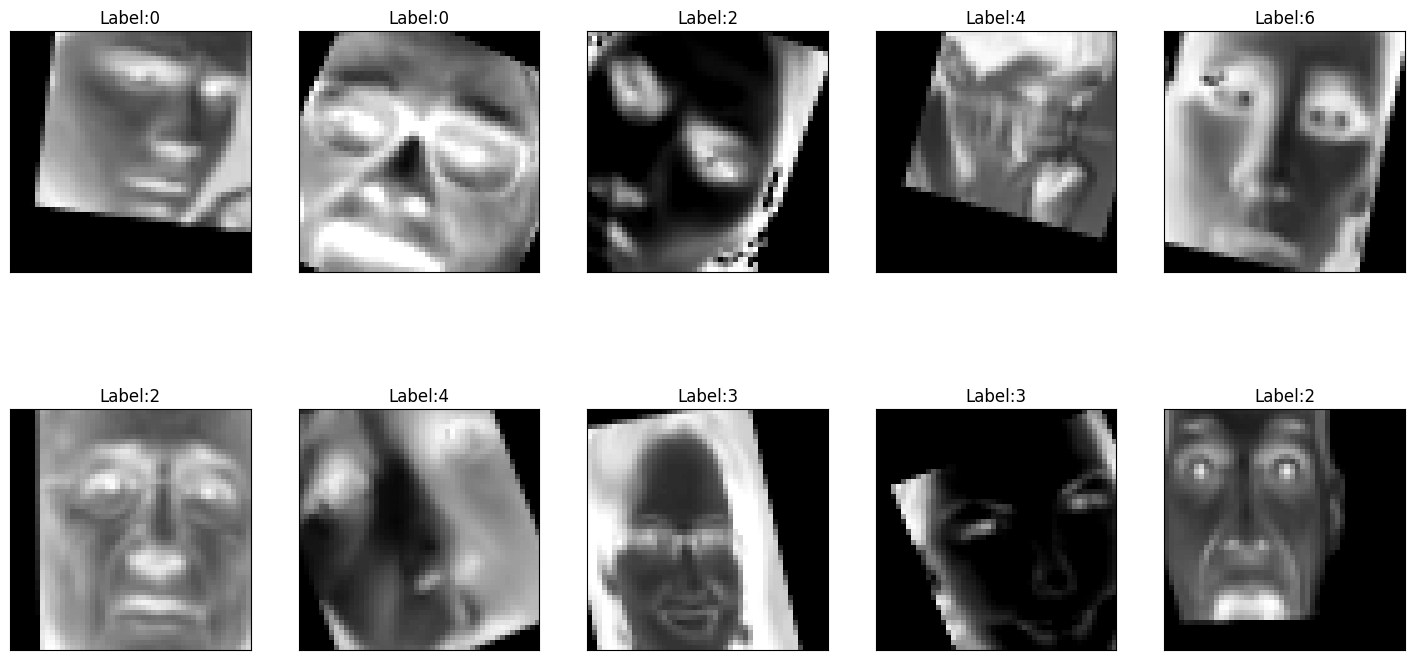

In [ ]:
# Data augmentation
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Lật ảnh ngang với xác suất 50%
    iaa.Crop(percent=(0, 0.1)),  # Cắt ngẫu nhiên ảnh với tỉ lệ từ 0 đến 10% mỗi chiều
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # Thay đổi tỉ lệ ảnh
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # Dịch chuyển ảnh
        rotate=(-25, 25),  # Xoay ảnh
        shear=(-8, 8)  # Biến dạng ảnh
    ),
    iaa.Multiply((0.8, 1.2)),  # Thay đổi độ sáng của ảnh
    iaa.ContrastNormalization((0.75, 1.5))  # Thay đổi độ tương phản của ảnh
])

# Convert images to uint8 before augmentation if they are in float format
if images.dtype == np.float64:
    images = (images * 255).astype(np.uint8)

# Áp dụng augmentation cho một vài hình ảnh để xem kết quả
images_aug = seq(images=images[:10])

# Hiển thị ảnh sau khi augmentation
show_img(images_aug, labels[:10])

In [ ]:
images_aug.shape

(10, 48, 48)

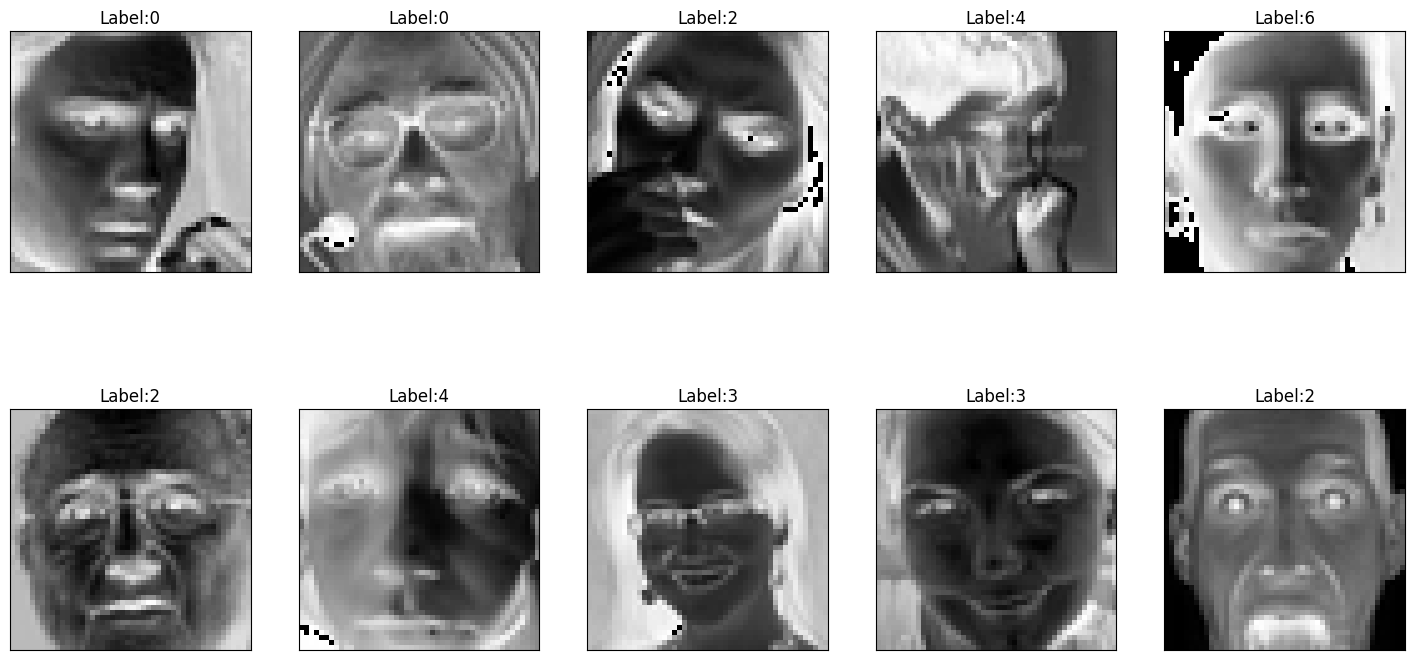

In [ ]:
# Tạo dữ liệu augmented đầy đủ
images_aug_full = seq(images=images)

# Kết hợp dữ liệu gốc và dữ liệu augmented
images_combined = np.concatenate((images, images_aug_full), axis=0)
labels_combined = np.concatenate((labels, labels), axis=0)

# Hiển thị một vài hình ảnh sau khi kết hợp dữ liệu
show_img(images_combined, labels_combined)

In [ ]:
images_combined.shape

(71774, 48, 48)

In [ ]:
labels_AUG = labels

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
# 1. Chuẩn hóa dữ liệu
images_combined = images / 255.0
images_combined

array([[[0.2745098 , 0.31372549, 0.32156863, ..., 0.20392157,
         0.16862745, 0.16078431],
        [0.25490196, 0.23921569, 0.22745098, ..., 0.21960784,
         0.20392157, 0.17254902],
        [0.19607843, 0.16862745, 0.21176471, ..., 0.19215686,
         0.21960784, 0.18431373],
        ...,
        [0.35686275, 0.25490196, 0.16470588, ..., 0.28235294,
         0.21960784, 0.16862745],
        [0.30196078, 0.32156863, 0.30980392, ..., 0.41176471,
         0.2745098 , 0.18039216],
        [0.30196078, 0.28235294, 0.32941176, ..., 0.41568627,
         0.42745098, 0.32156863]],

       [[0.59215686, 0.58823529, 0.57647059, ..., 0.50588235,
         0.54901961, 0.47058824],
        [0.59215686, 0.58431373, 0.58431373, ..., 0.47843137,
         0.55294118, 0.5372549 ],
        [0.59215686, 0.59215686, 0.61176471, ..., 0.42745098,
         0.48235294, 0.57254902],
        ...,
        [0.7372549 , 0.7372549 , 0.4745098 , ..., 0.7254902 ,
         0.7254902 , 0.72941176],
        [0.7

In [ ]:
# 2. Chuyển đổi nhãn sang One-Hot Encoding (giả sử biến `labels_AUG` chứa nhãn)
labels_AUG_one_hot = to_categorical(labels_combined, num_classes=7)

In [ ]:
# 3. Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(images_normalized,
                                                    labels_AUG_one_hot,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
# 4. Reshape hình ảnh (nếu cần)
# Nếu ảnh là grayscale, thêm một kênh vào cuối để có shape (num_samples, 48, 48, 1)
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

In [ ]:
""" 5. Xây dựng mô hình CNN """
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **ACCURACY ĐÃ HỘI TỤ Ở MỨC 52% SAU KHOẢNG 17 EPOCHS `TRÊN TẬP DỮ LIỆU CÓ AUGMENTATION`**

Ta dừng thực thi cell lại vì nó đã hội tụ rồi (cho đỡ tốn thời gian)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=25,
                    batch_size=64,
                    validation_data=(X_test,
                                     y_test))

Epoch 1/25
898/898 [==============================] - 253s 281ms/step - loss: 1.7715 - accuracy: 0.2694 - val_loss: 1.6720 - val_accuracy: 0.3255
Epoch 2/25
898/898 [==============================] - 287s 319ms/step - loss: 1.6339 - accuracy: 0.3469 - val_loss: 1.5216 - val_accuracy: 0.4049
Epoch 3/25
898/898 [==============================] - 253s 282ms/step - loss: 1.5290 - accuracy: 0.3973 - val_loss: 1.4216 - val_accuracy: 0.4504
Epoch 4/25
898/898 [==============================] - 251s 279ms/step - loss: 1.4687 - accuracy: 0.4257 - val_loss: 1.3741 - val_accuracy: 0.4692
Epoch 5/25
898/898 [==============================] - 252s 281ms/step - loss: 1.4273 - accuracy: 0.4487 - val_loss: 1.3611 - val_accuracy: 0.4731
Epoch 6/25
898/898 [==============================] - 243s 271ms/step - loss: 1.3955 - accuracy: 0.4613 - val_loss: 1.3215 - val_accuracy: 0.4967
Epoch 7/25
898/898 [==============================] - 243s 270ms/step - loss: 1.3660 - accuracy: 0.4731 - val_loss: 1.3002 -

KeyboardInterrupt: 

## 4. Evaluating Classification Performance

### **Question 4:**

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



### **Answer 4:**

Quá trình `evaluating` và `reporting` được thực hiện trong phần 3 phía trên.

1. Các "metric score" đều xêm xêm nhau, nên gần như không có class nào mà model predict sai nhiều. Tuy nhiên, với class `1`, ta thấy dữ liệu của class `1` rất ít, có nguy cơ model sẽ không thể predict tốt class này, nhưng một số model vẫn predict tốt (tốt so với các class còn lại) nếu như cho nó đủ số lần lặp và số lượng "lần mà model nhìn qua toàn bộ dữ liệu"

2. Class `5` luôn đạt những điểm số cao, chứng tỏ data (images) ở class 5 biểu diễn rất rõ thuộc tính của class đó.

3. Class `0` và class `4` thay phiên nhau đạt hiệu suất thấp trong tất cả các model trong thí nghiệm trong notebook này.

4. Tất cả các model machine learning trong notebook này đạt tối đa 45.4% accuracy

5. Model đạt accuracy cao nhất trong 3 file notebook đầu tiên là CNN() (Đạt 52%), bởi nó có kiến trúc của deep learning, phù hợp hơn đối với bài toán `image classification`, một bài toán mà vốn cần dùng deep learning chứ không phải machine learning truyền thống.